In [48]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU, BatchNormalization, LeakyReLU
from keras.losses import mse
from keras.constraints import non_neg

In [49]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [50]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [81]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=10000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [82]:
runs = [304125,304508,302263]

with open('normedAvg_data.pickle', 'rb') as handle:
    data = pickle.load(handle)
with open('normedAvg_bad.pickle', 'rb') as handle:
    bad_data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

x_bad1 = np.array(bad_data['301480']['samples'])
x_bad2 = np.array(bad_data['305588']['samples'])

WINDOW = 1

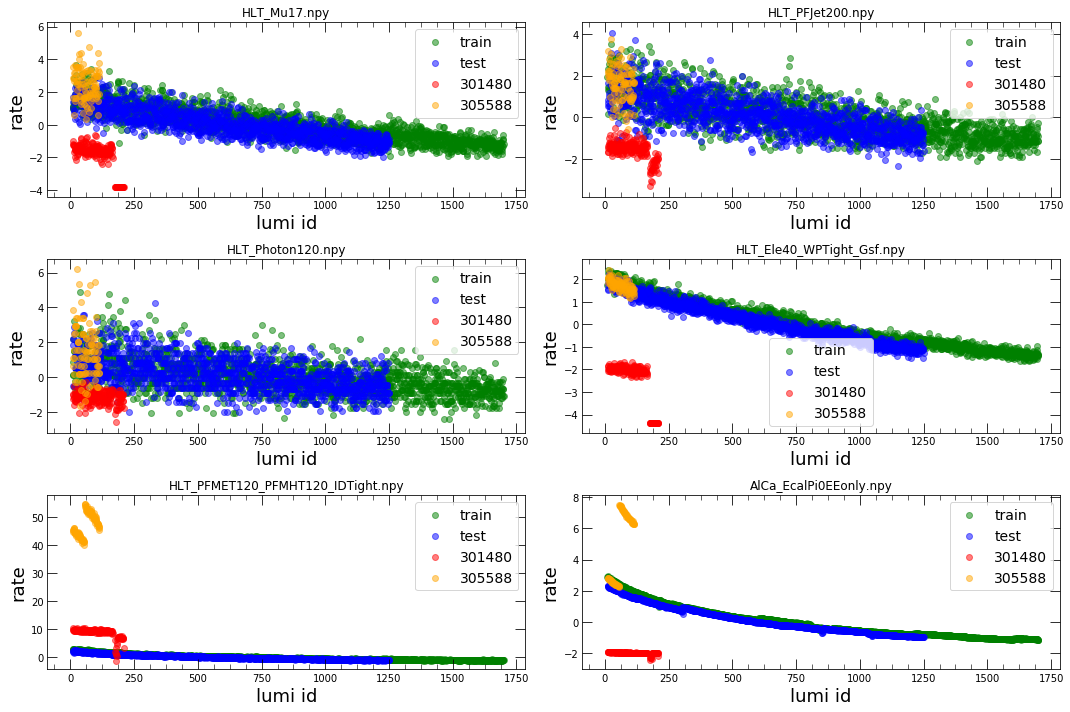

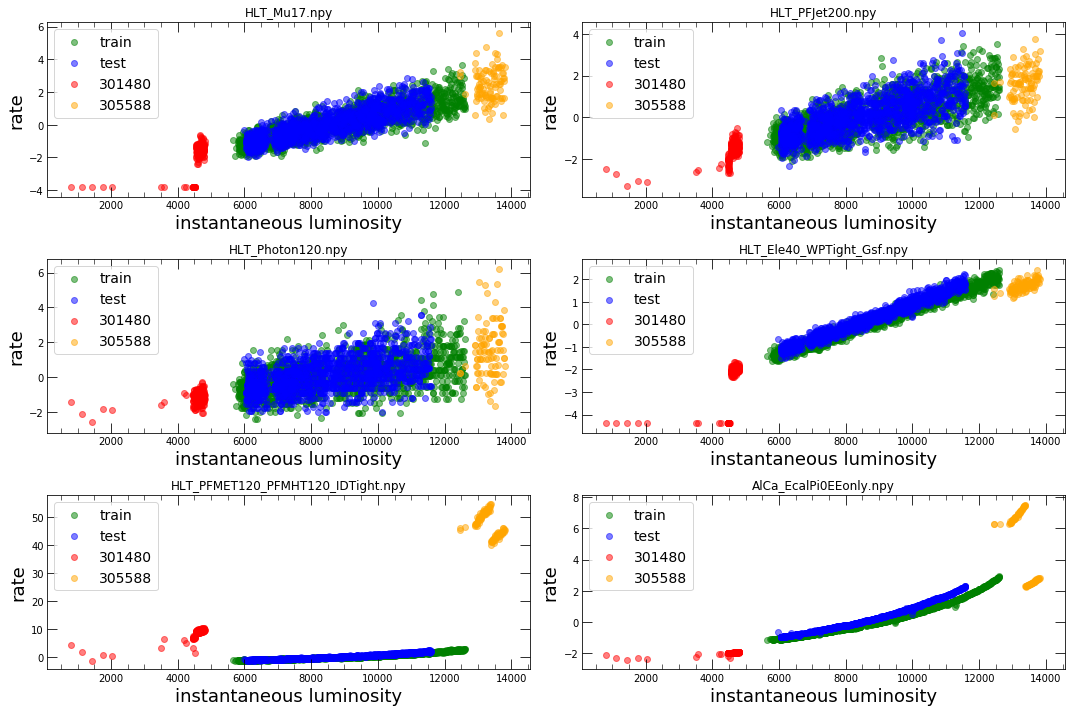

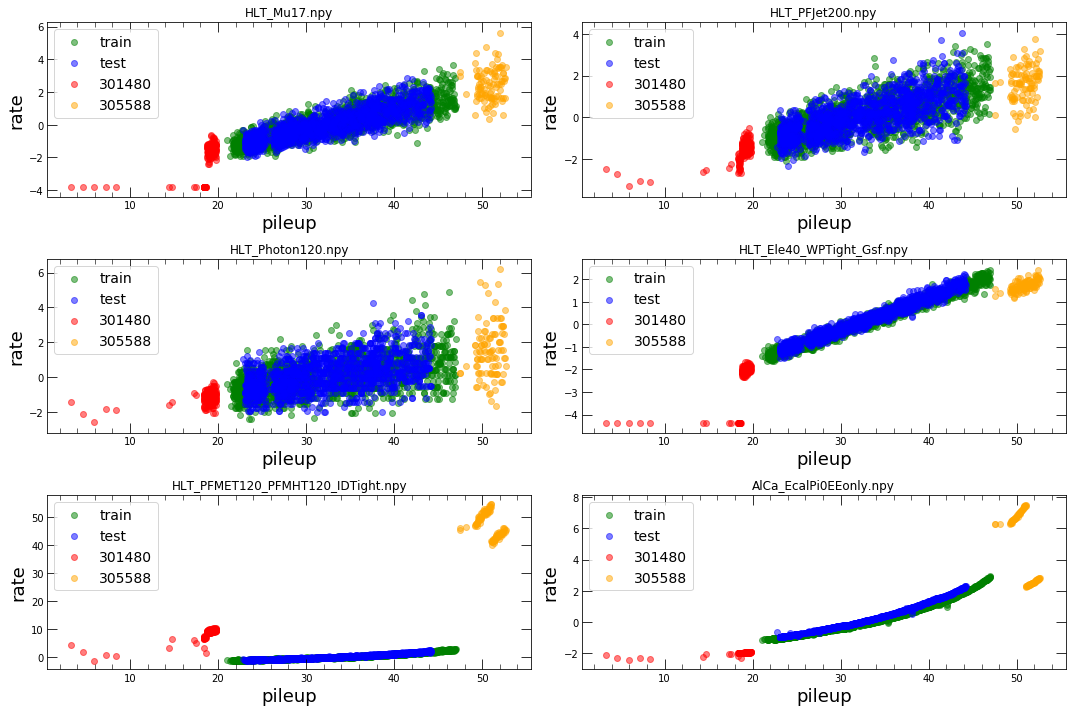

In [83]:
plots = [x_train,x_test,x_bad1,x_bad2]
titles = ["train","test","301480","305588"]

stuff = [[],[],[],[]]
lumi = [[],[],[],[]]
inst = [[],[],[],[]]
pileup = [[],[],[],[]]
for h in range(4):
    if h == 0 or h == 1:
        lumi[h] = data[str(runs[h])]['lumiid']
        inst[h] = data[str(runs[h])]['instlumi']
        pileup[h] = data[str(runs[h])]['pileup']
        stuff[h] = data[str(runs[h])]['rates']
    elif h == 2:
        lumi[h] = bad_data["301480"]['lumiid']
        inst[h] = bad_data["301480"]['instlumi']
        pileup[h] = bad_data["301480"]['pileup']
        stuff[h] = bad_data["301480"]['rates']
    else:
        lumi[h] = bad_data["305588"]['lumiid']
        inst[h] = bad_data["305588"]['instlumi']
        pileup[h] = bad_data["305588"]['pileup']
        stuff[h] = bad_data["305588"]['rates']
    
labels = data['HLT'] 
colors = ["g","b","r","orange"]
    
plt.figure(figsize=[15,10])
for i in range(6):
    plt.subplot(3,2,i+1)
    for k in range(0,4):
        #print(len(i[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(6):
    plt.subplot(3,2,i+1)
    for k in range(0,4):
        #print(len(inst[k][i]),len(stuff[k][i]))
        plt.scatter(inst[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('instantaneous luminosity')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(6):
    plt.subplot(3,2,i+1)
    for k in range(0,4):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(pileup[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Simple Autoencoder

In [84]:
model_name = "normavglayers"

In [85]:
# Define the architecture

_input = Input(shape=(6,), name="input")

hidden1 = Dense(6,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               name="hidden1")(_input)

active1 = PReLU()(hidden1)

hidden2 = Dense(4,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               name="hidden2")(active1)

active2 = PReLU()(hidden2)

hidden3 = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               name="encoded")(active2)

active3 = PReLU()(hidden3)

hidden4 = Dense(4,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               name="hidden4")(active3)

active4 = PReLU()(hidden4)

hidden5 = Dense(6,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               name="hidden5")(active4)

active5 = PReLU()(hidden5)

output = Dense(6,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(active5)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 6)                 0         
_________________________________________________________________
hidden1 (Dense)              (None, 6)                 42        
_________________________________________________________________
p_re_lu_25 (PReLU)           (None, 6)                 6         
_________________________________________________________________
hidden2 (Dense)              (None, 4)                 28        
_________________________________________________________________
p_re_lu_26 (PReLU)           (None, 4)                 4         
_________________________________________________________________
encoded (Dense)              (None, 3)                 15        
_________________________________________________________________
p_re_lu_27 (PReLU)           (None, 3)                 3         
__________

Train on 1669 samples, validate on 1224 samples
Epoch 1/10000
 - 10s - loss: 7447527.1702 - val_loss: 7281280.9428
Epoch 2/10000
 - 0s - loss: 6927825.3110 - val_loss: 6772986.6830
Epoch 3/10000
 - 0s - loss: 6447722.6126 - val_loss: 6316744.5915
Epoch 4/10000
 - 0s - loss: 6012360.3960 - val_loss: 5876684.8529
Epoch 5/10000
 - 0s - loss: 5593068.4170 - val_loss: 5470452.6095
Epoch 6/10000
 - 0s - loss: 5208075.8005 - val_loss: 5094235.8905
Epoch 7/10000
 - 0s - loss: 4847830.0437 - val_loss: 4747503.5997
Epoch 8/10000
 - 0s - loss: 4519484.4200 - val_loss: 4426920.0302
Epoch 9/10000
 - 0s - loss: 4214337.1436 - val_loss: 4130545.9853
Epoch 10/10000
 - 0s - loss: 3933730.1848 - val_loss: 3860634.0833
Epoch 11/10000
 - 0s - loss: 3675885.3936 - val_loss: 3611516.0776
Epoch 12/10000
 - 0s - loss: 3440177.5376 - val_loss: 3383940.1830
Epoch 13/10000
 - 0s - loss: 3225389.5301 - val_loss: 3174987.6511
Epoch 14/10000
 - 0s - loss: 3026607.6786 - val_loss: 2981119.6348
Epoch 15/10000
 - 0s -

Epoch 125/10000
 - 0s - loss: 171642.7837 - val_loss: 176073.2545
Epoch 126/10000
 - 0s - loss: 169431.5187 - val_loss: 173816.5836
Epoch 127/10000
 - 0s - loss: 167268.3268 - val_loss: 171600.7182
Epoch 128/10000
 - 0s - loss: 165138.9307 - val_loss: 169429.9511
Epoch 129/10000
 - 0s - loss: 163043.8351 - val_loss: 167298.0126
Epoch 130/10000
 - 0s - loss: 160989.9989 - val_loss: 165209.2463
Epoch 131/10000
 - 0s - loss: 159003.5151 - val_loss: 163153.2877
Epoch 132/10000
 - 0s - loss: 157030.0874 - val_loss: 161141.9671
Epoch 133/10000
 - 0s - loss: 155103.6487 - val_loss: 159168.5092
Epoch 134/10000
 - 0s - loss: 153187.0819 - val_loss: 157237.5387
Epoch 135/10000
 - 0s - loss: 151341.0107 - val_loss: 155338.6763
Epoch 136/10000
 - 0s - loss: 149512.6854 - val_loss: 153475.6634
Epoch 137/10000
 - 0s - loss: 147718.0473 - val_loss: 151646.8778
Epoch 138/10000
 - 0s - loss: 145964.7874 - val_loss: 149851.7206
Epoch 139/10000
 - 0s - loss: 144227.1281 - val_loss: 148088.5542
Epoch 140/

Epoch 252/10000
 - 0s - loss: 51896.3548 - val_loss: 53490.0783
Epoch 253/10000
 - 0s - loss: 51532.7270 - val_loss: 53114.3357
Epoch 254/10000
 - 0s - loss: 51167.9740 - val_loss: 52742.5417
Epoch 255/10000
 - 0s - loss: 50811.7910 - val_loss: 52374.2810
Epoch 256/10000
 - 0s - loss: 50457.9095 - val_loss: 52009.6430
Epoch 257/10000
 - 0s - loss: 50107.2685 - val_loss: 51648.8626
Epoch 258/10000
 - 0s - loss: 49759.3903 - val_loss: 51292.0857
Epoch 259/10000
 - 0s - loss: 49416.6228 - val_loss: 50938.8202
Epoch 260/10000
 - 0s - loss: 49077.5534 - val_loss: 50589.3137
Epoch 261/10000
 - 0s - loss: 48739.7179 - val_loss: 50243.7566
Epoch 262/10000
 - 0s - loss: 48407.5832 - val_loss: 49901.7050
Epoch 263/10000
 - 0s - loss: 48078.6019 - val_loss: 49563.0638
Epoch 264/10000
 - 0s - loss: 47750.8217 - val_loss: 49228.0802
Epoch 265/10000
 - 0s - loss: 47430.1348 - val_loss: 48896.2587
Epoch 266/10000
 - 0s - loss: 47110.9218 - val_loss: 48568.0791
Epoch 267/10000
 - 0s - loss: 46794.5640

Epoch 381/10000
 - 0s - loss: 24363.5935 - val_loss: 25154.5247
Epoch 382/10000
 - 0s - loss: 24244.4567 - val_loss: 25031.1842
Epoch 383/10000
 - 0s - loss: 24125.6006 - val_loss: 24908.7843
Epoch 384/10000
 - 0s - loss: 24007.3851 - val_loss: 24787.3708
Epoch 385/10000
 - 0s - loss: 23890.9885 - val_loss: 24666.7886
Epoch 386/10000
 - 0s - loss: 23774.0360 - val_loss: 24547.2194
Epoch 387/10000
 - 0s - loss: 23658.5724 - val_loss: 24428.4835
Epoch 388/10000
 - 0s - loss: 23544.6583 - val_loss: 24310.4052
Epoch 389/10000
 - 0s - loss: 23431.1699 - val_loss: 24193.1530
Epoch 390/10000
 - 0s - loss: 23317.8314 - val_loss: 24076.7904
Epoch 391/10000
 - 0s - loss: 23206.0727 - val_loss: 23961.2004
Epoch 392/10000
 - 0s - loss: 23094.6205 - val_loss: 23846.4955
Epoch 393/10000
 - 0s - loss: 22983.5246 - val_loss: 23732.6692
Epoch 394/10000
 - 0s - loss: 22874.1834 - val_loss: 23619.4963
Epoch 395/10000
 - 0s - loss: 22765.4634 - val_loss: 23507.0661
Epoch 396/10000
 - 0s - loss: 22657.1309

 - 0s - loss: 13991.3553 - val_loss: 14457.9165
Epoch 510/10000
 - 0s - loss: 13937.6808 - val_loss: 14402.5979
Epoch 511/10000
 - 0s - loss: 13884.3930 - val_loss: 14347.6063
Epoch 512/10000
 - 0s - loss: 13831.1754 - val_loss: 14292.9519
Epoch 513/10000
 - 0s - loss: 13778.5375 - val_loss: 14238.5706
Epoch 514/10000
 - 0s - loss: 13726.2805 - val_loss: 14184.4693
Epoch 515/10000
 - 0s - loss: 13673.8041 - val_loss: 14130.6904
Epoch 516/10000
 - 0s - loss: 13622.3295 - val_loss: 14077.1338
Epoch 517/10000
 - 0s - loss: 13570.7293 - val_loss: 14023.8996
Epoch 518/10000
 - 0s - loss: 13519.2581 - val_loss: 13970.9966
Epoch 519/10000
 - 0s - loss: 13468.4386 - val_loss: 13918.3512
Epoch 520/10000
 - 0s - loss: 13417.4925 - val_loss: 13866.0266
Epoch 521/10000
 - 0s - loss: 13367.3909 - val_loss: 13813.9225
Epoch 522/10000
 - 0s - loss: 13316.7976 - val_loss: 13762.1787
Epoch 523/10000
 - 0s - loss: 13266.9917 - val_loss: 13710.6677
Epoch 524/10000
 - 0s - loss: 13217.2000 - val_loss: 136

 - 0s - loss: 8920.2336 - val_loss: 9222.6579
Epoch 639/10000
 - 0s - loss: 8891.7403 - val_loss: 9193.3742
Epoch 640/10000
 - 0s - loss: 8863.3616 - val_loss: 9164.2155
Epoch 641/10000
 - 0s - loss: 8835.5732 - val_loss: 9135.1165
Epoch 642/10000
 - 0s - loss: 8807.5048 - val_loss: 9106.1879
Epoch 643/10000
 - 0s - loss: 8779.5204 - val_loss: 9077.4067
Epoch 644/10000
 - 0s - loss: 8751.8323 - val_loss: 9048.7439
Epoch 645/10000
 - 0s - loss: 8724.3635 - val_loss: 9020.2113
Epoch 646/10000
 - 0s - loss: 8696.7555 - val_loss: 8991.8498
Epoch 647/10000
 - 0s - loss: 8669.3195 - val_loss: 8963.6172
Epoch 648/10000
 - 0s - loss: 8642.1207 - val_loss: 8935.5022
Epoch 649/10000
 - 0s - loss: 8615.1790 - val_loss: 8907.4829
Epoch 650/10000
 - 0s - loss: 8588.0760 - val_loss: 8879.6273
Epoch 651/10000
 - 0s - loss: 8561.0730 - val_loss: 8851.9007
Epoch 652/10000
 - 0s - loss: 8534.2680 - val_loss: 8824.2692
Epoch 653/10000
 - 0s - loss: 8507.7480 - val_loss: 8796.7082
Epoch 654/10000
 - 0s - 

Epoch 771/10000
 - 0s - loss: 6027.1826 - val_loss: 6233.8444
Epoch 772/10000
 - 0s - loss: 6010.6518 - val_loss: 6216.8236
Epoch 773/10000
 - 0s - loss: 5994.3762 - val_loss: 6199.8425
Epoch 774/10000
 - 0s - loss: 5978.0293 - val_loss: 6182.9366
Epoch 775/10000
 - 0s - loss: 5961.7865 - val_loss: 6166.1065
Epoch 776/10000
 - 0s - loss: 5945.5351 - val_loss: 6149.3594
Epoch 777/10000
 - 0s - loss: 5929.3104 - val_loss: 6132.6913
Epoch 778/10000
 - 0s - loss: 5913.2508 - val_loss: 6116.0816
Epoch 779/10000
 - 0s - loss: 5897.2128 - val_loss: 6099.5250
Epoch 780/10000
 - 0s - loss: 5881.2736 - val_loss: 6083.0234
Epoch 781/10000
 - 0s - loss: 5865.3732 - val_loss: 6066.5822
Epoch 782/10000
 - 0s - loss: 5849.5095 - val_loss: 6050.2009
Epoch 783/10000
 - 0s - loss: 5833.7391 - val_loss: 6033.8743
Epoch 784/10000
 - 0s - loss: 5817.9181 - val_loss: 6017.6139
Epoch 785/10000
 - 0s - loss: 5802.4059 - val_loss: 6001.3890
Epoch 786/10000
 - 0s - loss: 5786.7853 - val_loss: 5985.2458
Epoch 78

 - 0s - loss: 4291.4886 - val_loss: 4439.7466
Epoch 904/10000
 - 0s - loss: 4281.1236 - val_loss: 4429.0006
Epoch 905/10000
 - 0s - loss: 4270.7631 - val_loss: 4418.2873
Epoch 906/10000
 - 0s - loss: 4260.3997 - val_loss: 4407.6127
Epoch 907/10000
 - 0s - loss: 4250.1559 - val_loss: 4396.9645
Epoch 908/10000
 - 0s - loss: 4239.8287 - val_loss: 4386.3600
Epoch 909/10000
 - 0s - loss: 4229.6388 - val_loss: 4375.7793
Epoch 910/10000
 - 0s - loss: 4219.4511 - val_loss: 4365.2312
Epoch 911/10000
 - 0s - loss: 4209.3086 - val_loss: 4354.7186
Epoch 912/10000
 - 0s - loss: 4199.1644 - val_loss: 4344.2494
Epoch 913/10000
 - 0s - loss: 4189.0625 - val_loss: 4333.8190
Epoch 914/10000
 - 0s - loss: 4178.9952 - val_loss: 4323.4230
Epoch 915/10000
 - 0s - loss: 4168.9326 - val_loss: 4313.0618
Epoch 916/10000
 - 0s - loss: 4158.9677 - val_loss: 4302.7219
Epoch 917/10000
 - 0s - loss: 4148.9974 - val_loss: 4292.4145
Epoch 918/10000
 - 0s - loss: 4139.0510 - val_loss: 4282.1393
Epoch 919/10000
 - 0s - 

Epoch 1035/10000
 - 0s - loss: 3164.9466 - val_loss: 3274.8608
Epoch 1036/10000
 - 0s - loss: 3157.9680 - val_loss: 3267.6774
Epoch 1037/10000
 - 0s - loss: 3151.0383 - val_loss: 3260.5084
Epoch 1038/10000
 - 0s - loss: 3144.1357 - val_loss: 3253.3583
Epoch 1039/10000
 - 0s - loss: 3137.2350 - val_loss: 3246.2273
Epoch 1040/10000
 - 0s - loss: 3130.4009 - val_loss: 3239.1136
Epoch 1041/10000
 - 0s - loss: 3123.5333 - val_loss: 3232.0262
Epoch 1042/10000
 - 0s - loss: 3116.6963 - val_loss: 3224.9631
Epoch 1043/10000
 - 0s - loss: 3109.8514 - val_loss: 3217.9255
Epoch 1044/10000
 - 0s - loss: 3103.0654 - val_loss: 3210.9003
Epoch 1045/10000
 - 0s - loss: 3096.3540 - val_loss: 3203.8888
Epoch 1046/10000
 - 0s - loss: 3089.5998 - val_loss: 3196.9084
Epoch 1047/10000
 - 0s - loss: 3082.7901 - val_loss: 3189.9578
Epoch 1048/10000
 - 0s - loss: 3076.0833 - val_loss: 3183.0179
Epoch 1049/10000
 - 0s - loss: 3069.4117 - val_loss: 3176.0867
Epoch 1050/10000
 - 0s - loss: 3062.7542 - val_loss: 31

Epoch 1166/10000
 - 0s - loss: 2401.4178 - val_loss: 2485.1904
Epoch 1167/10000
 - 0s - loss: 2396.5678 - val_loss: 2480.1757
Epoch 1168/10000
 - 0s - loss: 2391.7391 - val_loss: 2475.1692
Epoch 1169/10000
 - 0s - loss: 2386.9480 - val_loss: 2470.1713
Epoch 1170/10000
 - 0s - loss: 2382.0738 - val_loss: 2465.1955
Epoch 1171/10000
 - 0s - loss: 2377.3170 - val_loss: 2460.2234
Epoch 1172/10000
 - 0s - loss: 2372.5126 - val_loss: 2455.2686
Epoch 1173/10000
 - 0s - loss: 2367.7466 - val_loss: 2450.3262
Epoch 1174/10000
 - 0s - loss: 2362.9706 - val_loss: 2445.4002
Epoch 1175/10000
 - 0s - loss: 2358.2293 - val_loss: 2440.4852
Epoch 1176/10000
 - 0s - loss: 2353.4826 - val_loss: 2435.5865
Epoch 1177/10000
 - 0s - loss: 2348.7496 - val_loss: 2430.6998
Epoch 1178/10000
 - 0s - loss: 2344.0566 - val_loss: 2425.8251
Epoch 1179/10000
 - 0s - loss: 2339.3273 - val_loss: 2420.9656
Epoch 1180/10000
 - 0s - loss: 2334.6429 - val_loss: 2416.1143
Epoch 1181/10000
 - 0s - loss: 2329.9904 - val_loss: 24

 - 0s - loss: 1862.8200 - val_loss: 1928.0064
Epoch 1297/10000
 - 0s - loss: 1859.2999 - val_loss: 1924.3754
Epoch 1298/10000
 - 0s - loss: 1855.8288 - val_loss: 1920.7483
Epoch 1299/10000
 - 0s - loss: 1852.3164 - val_loss: 1917.1339
Epoch 1300/10000
 - 0s - loss: 1848.8239 - val_loss: 1913.5276
Epoch 1301/10000
 - 0s - loss: 1845.3445 - val_loss: 1909.9276
Epoch 1302/10000
 - 0s - loss: 1841.8913 - val_loss: 1906.3330
Epoch 1303/10000
 - 0s - loss: 1838.4458 - val_loss: 1902.7475
Epoch 1304/10000
 - 0s - loss: 1834.9531 - val_loss: 1899.1793
Epoch 1305/10000
 - 0s - loss: 1831.5189 - val_loss: 1895.6155
Epoch 1306/10000
 - 0s - loss: 1828.0702 - val_loss: 1892.0608
Epoch 1307/10000
 - 0s - loss: 1824.6428 - val_loss: 1888.5107
Epoch 1308/10000
 - 0s - loss: 1821.2376 - val_loss: 1884.9656
Epoch 1309/10000
 - 0s - loss: 1817.8138 - val_loss: 1881.4316
Epoch 1310/10000
 - 0s - loss: 1814.3986 - val_loss: 1877.9073
Epoch 1311/10000
 - 0s - loss: 1811.0153 - val_loss: 1874.3884
Epoch 131

Epoch 1427/10000
 - 0s - loss: 1465.1956 - val_loss: 1516.5868
Epoch 1428/10000
 - 0s - loss: 1462.5879 - val_loss: 1513.8842
Epoch 1429/10000
 - 0s - loss: 1459.9934 - val_loss: 1511.1900
Epoch 1430/10000
 - 0s - loss: 1457.3869 - val_loss: 1508.5048
Epoch 1431/10000
 - 0s - loss: 1454.8021 - val_loss: 1505.8277
Epoch 1432/10000
 - 0s - loss: 1452.2185 - val_loss: 1503.1584
Epoch 1433/10000
 - 0s - loss: 1449.6484 - val_loss: 1500.4954
Epoch 1434/10000
 - 0s - loss: 1447.0759 - val_loss: 1497.8405
Epoch 1435/10000
 - 0s - loss: 1444.5007 - val_loss: 1495.1920
Epoch 1436/10000
 - 0s - loss: 1441.9485 - val_loss: 1492.5474
Epoch 1437/10000
 - 0s - loss: 1439.4009 - val_loss: 1489.9054
Epoch 1438/10000
 - 0s - loss: 1436.8644 - val_loss: 1487.2684
Epoch 1439/10000
 - 0s - loss: 1434.3011 - val_loss: 1484.6397
Epoch 1440/10000
 - 0s - loss: 1431.7751 - val_loss: 1482.0127
Epoch 1441/10000
 - 0s - loss: 1429.2338 - val_loss: 1479.3917
Epoch 1442/10000
 - 0s - loss: 1426.7235 - val_loss: 14

Epoch 1558/10000
 - 0s - loss: 1167.3438 - val_loss: 1208.3752
Epoch 1559/10000
 - 0s - loss: 1165.3667 - val_loss: 1206.3321
Epoch 1560/10000
 - 0s - loss: 1163.3979 - val_loss: 1204.2931
Epoch 1561/10000
 - 0s - loss: 1161.4398 - val_loss: 1202.2577
Epoch 1562/10000
 - 0s - loss: 1159.4707 - val_loss: 1200.2289
Epoch 1563/10000
 - 0s - loss: 1157.5020 - val_loss: 1198.2047
Epoch 1564/10000
 - 0s - loss: 1155.5660 - val_loss: 1196.1819
Epoch 1565/10000
 - 0s - loss: 1153.6040 - val_loss: 1194.1645
Epoch 1566/10000
 - 0s - loss: 1151.6679 - val_loss: 1192.1496
Epoch 1567/10000
 - 0s - loss: 1149.7107 - val_loss: 1190.1410
Epoch 1568/10000
 - 0s - loss: 1147.7784 - val_loss: 1188.1336
Epoch 1569/10000
 - 0s - loss: 1145.8495 - val_loss: 1186.1293
Epoch 1570/10000
 - 0s - loss: 1143.9097 - val_loss: 1184.1304
Epoch 1571/10000
 - 0s - loss: 1141.9863 - val_loss: 1182.1347
Epoch 1572/10000
 - 0s - loss: 1140.0586 - val_loss: 1180.1432
Epoch 1573/10000
 - 0s - loss: 1138.1361 - val_loss: 11

Epoch 1689/10000
 - 0s - loss: 939.6175 - val_loss: 972.7165
Epoch 1690/10000
 - 0s - loss: 938.1136 - val_loss: 971.1393
Epoch 1691/10000
 - 0s - loss: 936.5907 - val_loss: 969.5661
Epoch 1692/10000
 - 0s - loss: 935.0718 - val_loss: 967.9970
Epoch 1693/10000
 - 0s - loss: 933.5585 - val_loss: 966.4311
Epoch 1694/10000
 - 0s - loss: 932.0518 - val_loss: 964.8676
Epoch 1695/10000
 - 0s - loss: 930.5495 - val_loss: 963.3077
Epoch 1696/10000
 - 0s - loss: 929.0404 - val_loss: 961.7532
Epoch 1697/10000
 - 0s - loss: 927.5275 - val_loss: 960.2023
Epoch 1698/10000
 - 0s - loss: 926.0332 - val_loss: 958.6517
Epoch 1699/10000
 - 0s - loss: 924.5418 - val_loss: 957.1023
Epoch 1700/10000
 - 0s - loss: 923.0527 - val_loss: 955.5550
Epoch 1701/10000
 - 0s - loss: 921.5641 - val_loss: 954.0111
Epoch 1702/10000
 - 0s - loss: 920.0667 - val_loss: 952.4718
Epoch 1703/10000
 - 0s - loss: 918.5910 - val_loss: 950.9345
Epoch 1704/10000
 - 0s - loss: 917.1012 - val_loss: 949.4013
Epoch 1705/10000
 - 0s -

Epoch 1824/10000
 - 0s - loss: 758.1297 - val_loss: 784.8684
Epoch 1825/10000
 - 0s - loss: 756.9518 - val_loss: 783.6460
Epoch 1826/10000
 - 0s - loss: 755.7761 - val_loss: 782.4252
Epoch 1827/10000
 - 0s - loss: 754.6061 - val_loss: 781.2062
Epoch 1828/10000
 - 0s - loss: 753.4182 - val_loss: 779.9921
Epoch 1829/10000
 - 0s - loss: 752.2469 - val_loss: 778.7784
Epoch 1830/10000
 - 0s - loss: 751.0763 - val_loss: 777.5662
Epoch 1831/10000
 - 0s - loss: 749.9121 - val_loss: 776.3550
Epoch 1832/10000
 - 0s - loss: 748.7414 - val_loss: 775.1463
Epoch 1833/10000
 - 0s - loss: 747.5794 - val_loss: 773.9392
Epoch 1834/10000
 - 0s - loss: 746.4186 - val_loss: 772.7348
Epoch 1835/10000
 - 0s - loss: 745.2589 - val_loss: 771.5340
Epoch 1836/10000
 - 0s - loss: 744.0812 - val_loss: 770.3372
Epoch 1837/10000
 - 0s - loss: 742.9404 - val_loss: 769.1388
Epoch 1838/10000
 - 0s - loss: 741.7844 - val_loss: 767.9431
Epoch 1839/10000
 - 0s - loss: 740.6315 - val_loss: 766.7495
Epoch 1840/10000
 - 0s -

Epoch 1959/10000
 - 0s - loss: 616.2737 - val_loss: 638.0304
Epoch 1960/10000
 - 0s - loss: 615.3451 - val_loss: 637.0685
Epoch 1961/10000
 - 0s - loss: 614.4185 - val_loss: 636.1082
Epoch 1962/10000
 - 0s - loss: 613.4884 - val_loss: 635.1501
Epoch 1963/10000
 - 0s - loss: 612.5615 - val_loss: 634.1933
Epoch 1964/10000
 - 0s - loss: 611.6457 - val_loss: 633.2366
Epoch 1965/10000
 - 0s - loss: 610.7236 - val_loss: 632.2820
Epoch 1966/10000
 - 0s - loss: 609.8000 - val_loss: 631.3297
Epoch 1967/10000
 - 0s - loss: 608.8801 - val_loss: 630.3791
Epoch 1968/10000
 - 0s - loss: 607.9663 - val_loss: 629.4294
Epoch 1969/10000
 - 0s - loss: 607.0497 - val_loss: 628.4814
Epoch 1970/10000
 - 0s - loss: 606.1378 - val_loss: 627.5354
Epoch 1971/10000
 - 0s - loss: 605.2201 - val_loss: 626.5918
Epoch 1972/10000
 - 0s - loss: 604.3157 - val_loss: 625.6486
Epoch 1973/10000
 - 0s - loss: 603.4104 - val_loss: 624.7076
Epoch 1974/10000
 - 0s - loss: 602.4989 - val_loss: 623.7697
Epoch 1975/10000
 - 0s -

Epoch 2094/10000
 - 0s - loss: 504.0950 - val_loss: 521.9118
Epoch 2095/10000
 - 0s - loss: 503.3559 - val_loss: 521.1461
Epoch 2096/10000
 - 0s - loss: 502.6190 - val_loss: 520.3810
Epoch 2097/10000
 - 0s - loss: 501.8864 - val_loss: 519.6169
Epoch 2098/10000
 - 0s - loss: 501.1444 - val_loss: 518.8554
Epoch 2099/10000
 - 0s - loss: 500.4099 - val_loss: 518.0949
Epoch 2100/10000
 - 0s - loss: 499.6808 - val_loss: 517.3353
Epoch 2101/10000
 - 0s - loss: 498.9433 - val_loss: 516.5780
Epoch 2102/10000
 - 0s - loss: 498.2153 - val_loss: 515.8211
Epoch 2103/10000
 - 0s - loss: 497.4866 - val_loss: 515.0655
Epoch 2104/10000
 - 0s - loss: 496.7559 - val_loss: 514.3118
Epoch 2105/10000
 - 0s - loss: 496.0304 - val_loss: 513.5591
Epoch 2106/10000
 - 0s - loss: 495.3049 - val_loss: 512.8077
Epoch 2107/10000
 - 0s - loss: 494.5771 - val_loss: 512.0582
Epoch 2108/10000
 - 0s - loss: 493.8566 - val_loss: 511.3091
Epoch 2109/10000
 - 0s - loss: 493.1350 - val_loss: 510.5614
Epoch 2110/10000
 - 0s -

Epoch 2229/10000
 - 0s - loss: 414.5336 - val_loss: 429.1961
Epoch 2230/10000
 - 0s - loss: 413.9448 - val_loss: 428.5821
Epoch 2231/10000
 - 0s - loss: 413.3511 - val_loss: 427.9695
Epoch 2232/10000
 - 0s - loss: 412.7565 - val_loss: 427.3580
Epoch 2233/10000
 - 0s - loss: 412.1685 - val_loss: 426.7469
Epoch 2234/10000
 - 0s - loss: 411.5828 - val_loss: 426.1362
Epoch 2235/10000
 - 0s - loss: 410.9911 - val_loss: 425.5273
Epoch 2236/10000
 - 0s - loss: 410.4046 - val_loss: 424.9193
Epoch 2237/10000
 - 0s - loss: 409.8176 - val_loss: 424.3122
Epoch 2238/10000
 - 0s - loss: 409.2326 - val_loss: 423.7061
Epoch 2239/10000
 - 0s - loss: 408.6453 - val_loss: 423.1013
Epoch 2240/10000
 - 0s - loss: 408.0660 - val_loss: 422.4964
Epoch 2241/10000
 - 0s - loss: 407.4805 - val_loss: 421.8931
Epoch 2242/10000
 - 0s - loss: 406.9028 - val_loss: 421.2905
Epoch 2243/10000
 - 0s - loss: 406.3186 - val_loss: 420.6898
Epoch 2244/10000
 - 0s - loss: 405.7414 - val_loss: 420.0896
Epoch 2245/10000
 - 0s -

Epoch 2364/10000
 - 0s - loss: 342.3945 - val_loss: 354.5120
Epoch 2365/10000
 - 0s - loss: 341.9146 - val_loss: 354.0156
Epoch 2366/10000
 - 0s - loss: 341.4375 - val_loss: 353.5198
Epoch 2367/10000
 - 0s - loss: 340.9604 - val_loss: 353.0251
Epoch 2368/10000
 - 0s - loss: 340.4788 - val_loss: 352.5318
Epoch 2369/10000
 - 0s - loss: 340.0028 - val_loss: 352.0385
Epoch 2370/10000
 - 0s - loss: 339.5305 - val_loss: 351.5455
Epoch 2371/10000
 - 0s - loss: 339.0533 - val_loss: 351.0534
Epoch 2372/10000
 - 0s - loss: 338.5788 - val_loss: 350.5621
Epoch 2373/10000
 - 0s - loss: 338.1034 - val_loss: 350.0713
Epoch 2374/10000
 - 0s - loss: 337.6333 - val_loss: 349.5810
Epoch 2375/10000
 - 0s - loss: 337.1591 - val_loss: 349.0918
Epoch 2376/10000
 - 0s - loss: 336.6876 - val_loss: 348.6033
Epoch 2377/10000
 - 0s - loss: 336.2163 - val_loss: 348.1158
Epoch 2378/10000
 - 0s - loss: 335.7460 - val_loss: 347.6289
Epoch 2379/10000
 - 0s - loss: 335.2768 - val_loss: 347.1428
Epoch 2380/10000
 - 0s -

Epoch 2499/10000
 - 0s - loss: 283.8396 - val_loss: 293.8912
Epoch 2500/10000
 - 0s - loss: 283.4496 - val_loss: 293.4869
Epoch 2501/10000
 - 0s - loss: 283.0585 - val_loss: 293.0833
Epoch 2502/10000
 - 0s - loss: 282.6713 - val_loss: 292.6799
Epoch 2503/10000
 - 0s - loss: 282.2815 - val_loss: 292.2774
Epoch 2504/10000
 - 0s - loss: 281.8923 - val_loss: 291.8755
Epoch 2505/10000
 - 0s - loss: 281.5055 - val_loss: 291.4741
Epoch 2506/10000
 - 0s - loss: 281.1217 - val_loss: 291.0730
Epoch 2507/10000
 - 0s - loss: 280.7329 - val_loss: 290.6732
Epoch 2508/10000
 - 0s - loss: 280.3434 - val_loss: 290.2746
Epoch 2509/10000
 - 0s - loss: 279.9609 - val_loss: 289.8756
Epoch 2510/10000
 - 0s - loss: 279.5763 - val_loss: 289.4772
Epoch 2511/10000
 - 0s - loss: 279.1912 - val_loss: 289.0792
Epoch 2512/10000
 - 0s - loss: 278.8101 - val_loss: 288.6815
Epoch 2513/10000
 - 0s - loss: 278.4227 - val_loss: 288.2849
Epoch 2514/10000
 - 0s - loss: 278.0420 - val_loss: 287.8884
Epoch 2515/10000
 - 0s -

Epoch 2634/10000
 - 0s - loss: 236.0263 - val_loss: 244.3889
Epoch 2635/10000
 - 0s - loss: 235.7076 - val_loss: 244.0578
Epoch 2636/10000
 - 0s - loss: 235.3866 - val_loss: 243.7274
Epoch 2637/10000
 - 0s - loss: 235.0683 - val_loss: 243.3970
Epoch 2638/10000
 - 0s - loss: 234.7515 - val_loss: 243.0669
Epoch 2639/10000
 - 0s - loss: 234.4319 - val_loss: 242.7377
Epoch 2640/10000
 - 0s - loss: 234.1133 - val_loss: 242.4089
Epoch 2641/10000
 - 0s - loss: 233.7972 - val_loss: 242.0804
Epoch 2642/10000
 - 0s - loss: 233.4816 - val_loss: 241.7523
Epoch 2643/10000
 - 0s - loss: 233.1626 - val_loss: 241.4249
Epoch 2644/10000
 - 0s - loss: 232.8481 - val_loss: 241.0978
Epoch 2645/10000
 - 0s - loss: 232.5338 - val_loss: 240.7711
Epoch 2646/10000
 - 0s - loss: 232.2213 - val_loss: 240.4448
Epoch 2647/10000
 - 0s - loss: 231.9032 - val_loss: 240.1200
Epoch 2648/10000
 - 0s - loss: 231.5896 - val_loss: 239.7956
Epoch 2649/10000
 - 0s - loss: 231.2757 - val_loss: 239.4714
Epoch 2650/10000
 - 0s -

Epoch 2769/10000
 - 0s - loss: 196.7953 - val_loss: 203.7687
Epoch 2770/10000
 - 0s - loss: 196.5306 - val_loss: 203.4967
Epoch 2771/10000
 - 0s - loss: 196.2670 - val_loss: 203.2250
Epoch 2772/10000
 - 0s - loss: 196.0066 - val_loss: 202.9532
Epoch 2773/10000
 - 0s - loss: 195.7442 - val_loss: 202.6818
Epoch 2774/10000
 - 0s - loss: 195.4820 - val_loss: 202.4109
Epoch 2775/10000
 - 0s - loss: 195.2211 - val_loss: 202.1402
Epoch 2776/10000
 - 0s - loss: 194.9599 - val_loss: 201.8699
Epoch 2777/10000
 - 0s - loss: 194.6997 - val_loss: 201.6000
Epoch 2778/10000
 - 0s - loss: 194.4389 - val_loss: 201.3306
Epoch 2779/10000
 - 0s - loss: 194.1805 - val_loss: 201.0615
Epoch 2780/10000
 - 0s - loss: 193.9193 - val_loss: 200.7930
Epoch 2781/10000
 - 0s - loss: 193.6624 - val_loss: 200.5247
Epoch 2782/10000
 - 0s - loss: 193.4021 - val_loss: 200.2572
Epoch 2783/10000
 - 0s - loss: 193.1447 - val_loss: 199.9899
Epoch 2784/10000
 - 0s - loss: 192.8870 - val_loss: 199.7231
Epoch 2785/10000
 - 0s -

Epoch 2904/10000
 - 0s - loss: 164.4404 - val_loss: 170.2701
Epoch 2905/10000
 - 0s - loss: 164.2239 - val_loss: 170.0449
Epoch 2906/10000
 - 0s - loss: 164.0064 - val_loss: 169.8203
Epoch 2907/10000
 - 0s - loss: 163.7891 - val_loss: 169.5962
Epoch 2908/10000
 - 0s - loss: 163.5715 - val_loss: 169.3725
Epoch 2909/10000
 - 0s - loss: 163.3568 - val_loss: 169.1486
Epoch 2910/10000
 - 0s - loss: 163.1411 - val_loss: 168.9250
Epoch 2911/10000
 - 0s - loss: 162.9244 - val_loss: 168.7018
Epoch 2912/10000
 - 0s - loss: 162.7108 - val_loss: 168.4786
Epoch 2913/10000
 - 0s - loss: 162.4942 - val_loss: 168.2561
Epoch 2914/10000
 - 0s - loss: 162.2809 - val_loss: 168.0334
Epoch 2915/10000
 - 0s - loss: 162.0644 - val_loss: 167.8116
Epoch 2916/10000
 - 0s - loss: 161.8514 - val_loss: 167.5897
Epoch 2917/10000
 - 0s - loss: 161.6379 - val_loss: 167.3681
Epoch 2918/10000
 - 0s - loss: 161.4238 - val_loss: 167.1470
Epoch 2919/10000
 - 0s - loss: 161.2091 - val_loss: 166.9262
Epoch 2920/10000
 - 0s -

Epoch 3039/10000
 - 0s - loss: 137.6588 - val_loss: 142.5414
Epoch 3040/10000
 - 0s - loss: 137.4789 - val_loss: 142.3542
Epoch 3041/10000
 - 0s - loss: 137.2978 - val_loss: 142.1675
Epoch 3042/10000
 - 0s - loss: 137.1193 - val_loss: 141.9808
Epoch 3043/10000
 - 0s - loss: 136.9387 - val_loss: 141.7946
Epoch 3044/10000
 - 0s - loss: 136.7596 - val_loss: 141.6088
Epoch 3045/10000
 - 0s - loss: 136.5798 - val_loss: 141.4234
Epoch 3046/10000
 - 0s - loss: 136.4004 - val_loss: 141.2383
Epoch 3047/10000
 - 0s - loss: 136.2238 - val_loss: 141.0532
Epoch 3048/10000
 - 0s - loss: 136.0439 - val_loss: 140.8687
Epoch 3049/10000
 - 0s - loss: 135.8669 - val_loss: 140.6845
Epoch 3050/10000
 - 0s - loss: 135.6887 - val_loss: 140.5005
Epoch 3051/10000
 - 0s - loss: 135.5112 - val_loss: 140.3169
Epoch 3052/10000
 - 0s - loss: 135.3341 - val_loss: 140.1337
Epoch 3053/10000
 - 0s - loss: 135.1563 - val_loss: 139.9506
Epoch 3054/10000
 - 0s - loss: 134.9800 - val_loss: 139.7675
Epoch 3055/10000
 - 0s -

Epoch 3174/10000
 - 0s - loss: 115.4312 - val_loss: 119.5268
Epoch 3175/10000
 - 0s - loss: 115.2822 - val_loss: 119.3713
Epoch 3176/10000
 - 0s - loss: 115.1322 - val_loss: 119.2161
Epoch 3177/10000
 - 0s - loss: 114.9835 - val_loss: 119.0610
Epoch 3178/10000
 - 0s - loss: 114.8330 - val_loss: 118.9064
Epoch 3179/10000
 - 0s - loss: 114.6845 - val_loss: 118.7520
Epoch 3180/10000
 - 0s - loss: 114.5350 - val_loss: 118.5978
Epoch 3181/10000
 - 0s - loss: 114.3865 - val_loss: 118.4438
Epoch 3182/10000
 - 0s - loss: 114.2378 - val_loss: 118.2902
Epoch 3183/10000
 - 0s - loss: 114.0893 - val_loss: 118.1366
Epoch 3184/10000
 - 0s - loss: 113.9416 - val_loss: 117.9832
Epoch 3185/10000
 - 0s - loss: 113.7939 - val_loss: 117.8300
Epoch 3186/10000
 - 0s - loss: 113.6458 - val_loss: 117.6771
Epoch 3187/10000
 - 0s - loss: 113.4987 - val_loss: 117.5243
Epoch 3188/10000
 - 0s - loss: 113.3514 - val_loss: 117.3719
Epoch 3189/10000
 - 0s - loss: 113.2043 - val_loss: 117.2197
Epoch 3190/10000
 - 0s -

Epoch 3309/10000
 - 0s - loss: 96.9206 - val_loss: 100.3589
Epoch 3310/10000
 - 0s - loss: 96.7956 - val_loss: 100.2296
Epoch 3311/10000
 - 0s - loss: 96.6710 - val_loss: 100.1005
Epoch 3312/10000
 - 0s - loss: 96.5461 - val_loss: 99.9716
Epoch 3313/10000
 - 0s - loss: 96.4224 - val_loss: 99.8427
Epoch 3314/10000
 - 0s - loss: 96.2984 - val_loss: 99.7141
Epoch 3315/10000
 - 0s - loss: 96.1738 - val_loss: 99.5858
Epoch 3316/10000
 - 0s - loss: 96.0505 - val_loss: 99.4577
Epoch 3317/10000
 - 0s - loss: 95.9256 - val_loss: 99.3299
Epoch 3318/10000
 - 0s - loss: 95.8024 - val_loss: 99.2020
Epoch 3319/10000
 - 0s - loss: 95.6798 - val_loss: 99.0741
Epoch 3320/10000
 - 0s - loss: 95.5556 - val_loss: 98.9465
Epoch 3321/10000
 - 0s - loss: 95.4328 - val_loss: 98.8188
Epoch 3322/10000
 - 0s - loss: 95.3101 - val_loss: 98.6913
Epoch 3323/10000
 - 0s - loss: 95.1874 - val_loss: 98.5640
Epoch 3324/10000
 - 0s - loss: 95.0640 - val_loss: 98.4369
Epoch 3325/10000
 - 0s - loss: 94.9414 - val_loss: 98

Epoch 3448/10000
 - 0s - loss: 81.0536 - val_loss: 83.9286
Epoch 3449/10000
 - 0s - loss: 80.9485 - val_loss: 83.8211
Epoch 3450/10000
 - 0s - loss: 80.8452 - val_loss: 83.7136
Epoch 3451/10000
 - 0s - loss: 80.7418 - val_loss: 83.6062
Epoch 3452/10000
 - 0s - loss: 80.6378 - val_loss: 83.4991
Epoch 3453/10000
 - 0s - loss: 80.5349 - val_loss: 83.3921
Epoch 3454/10000
 - 0s - loss: 80.4308 - val_loss: 83.2854
Epoch 3455/10000
 - 0s - loss: 80.3283 - val_loss: 83.1786
Epoch 3456/10000
 - 0s - loss: 80.2256 - val_loss: 83.0719
Epoch 3457/10000
 - 0s - loss: 80.1223 - val_loss: 82.9654
Epoch 3458/10000
 - 0s - loss: 80.0201 - val_loss: 82.8590
Epoch 3459/10000
 - 0s - loss: 79.9173 - val_loss: 82.7528
Epoch 3460/10000
 - 0s - loss: 79.8147 - val_loss: 82.6468
Epoch 3461/10000
 - 0s - loss: 79.7121 - val_loss: 82.5409
Epoch 3462/10000
 - 0s - loss: 79.6107 - val_loss: 82.4350
Epoch 3463/10000
 - 0s - loss: 79.5085 - val_loss: 82.3294
Epoch 3464/10000
 - 0s - loss: 79.4067 - val_loss: 82.22

Epoch 3587/10000
 - 0s - loss: 67.8435 - val_loss: 70.2516
Epoch 3588/10000
 - 0s - loss: 67.7579 - val_loss: 70.1619
Epoch 3589/10000
 - 0s - loss: 67.6713 - val_loss: 70.0725
Epoch 3590/10000
 - 0s - loss: 67.5852 - val_loss: 69.9831
Epoch 3591/10000
 - 0s - loss: 67.4990 - val_loss: 69.8940
Epoch 3592/10000
 - 0s - loss: 67.4124 - val_loss: 69.8050
Epoch 3593/10000
 - 0s - loss: 67.3272 - val_loss: 69.7160
Epoch 3594/10000
 - 0s - loss: 67.2410 - val_loss: 69.6272
Epoch 3595/10000
 - 0s - loss: 67.1557 - val_loss: 69.5385
Epoch 3596/10000
 - 0s - loss: 67.0700 - val_loss: 69.4499
Epoch 3597/10000
 - 0s - loss: 66.9842 - val_loss: 69.3615
Epoch 3598/10000
 - 0s - loss: 66.8987 - val_loss: 69.2731
Epoch 3599/10000
 - 0s - loss: 66.8135 - val_loss: 69.1847
Epoch 3600/10000
 - 0s - loss: 66.7287 - val_loss: 69.0964
Epoch 3601/10000
 - 0s - loss: 66.6434 - val_loss: 69.0083
Epoch 3602/10000
 - 0s - loss: 66.5584 - val_loss: 68.9202
Epoch 3603/10000
 - 0s - loss: 66.4734 - val_loss: 68.83

Epoch 3726/10000
 - 0s - loss: 56.8337 - val_loss: 58.8504
Epoch 3727/10000
 - 0s - loss: 56.7611 - val_loss: 58.7756
Epoch 3728/10000
 - 0s - loss: 56.6894 - val_loss: 58.7009
Epoch 3729/10000
 - 0s - loss: 56.6170 - val_loss: 58.6263
Epoch 3730/10000
 - 0s - loss: 56.5453 - val_loss: 58.5518
Epoch 3731/10000
 - 0s - loss: 56.4734 - val_loss: 58.4774
Epoch 3732/10000
 - 0s - loss: 56.4014 - val_loss: 58.4031
Epoch 3733/10000
 - 0s - loss: 56.3302 - val_loss: 58.3289
Epoch 3734/10000
 - 0s - loss: 56.2584 - val_loss: 58.2548
Epoch 3735/10000
 - 0s - loss: 56.1867 - val_loss: 58.1808
Epoch 3736/10000
 - 0s - loss: 56.1153 - val_loss: 58.1069
Epoch 3737/10000
 - 0s - loss: 56.0445 - val_loss: 58.0330
Epoch 3738/10000
 - 0s - loss: 55.9731 - val_loss: 57.9592
Epoch 3739/10000
 - 0s - loss: 55.9018 - val_loss: 57.8856
Epoch 3740/10000
 - 0s - loss: 55.8312 - val_loss: 57.8120
Epoch 3741/10000
 - 0s - loss: 55.7598 - val_loss: 57.7387
Epoch 3742/10000
 - 0s - loss: 55.6893 - val_loss: 57.66

Epoch 3865/10000
 - 0s - loss: 47.6401 - val_loss: 49.3308
Epoch 3866/10000
 - 0s - loss: 47.5800 - val_loss: 49.2683
Epoch 3867/10000
 - 0s - loss: 47.5194 - val_loss: 49.2059
Epoch 3868/10000
 - 0s - loss: 47.4595 - val_loss: 49.1435
Epoch 3869/10000
 - 0s - loss: 47.3991 - val_loss: 49.0813
Epoch 3870/10000
 - 0s - loss: 47.3393 - val_loss: 49.0192
Epoch 3871/10000
 - 0s - loss: 47.2790 - val_loss: 48.9571
Epoch 3872/10000
 - 0s - loss: 47.2196 - val_loss: 48.8950
Epoch 3873/10000
 - 0s - loss: 47.1594 - val_loss: 48.8331
Epoch 3874/10000
 - 0s - loss: 47.1001 - val_loss: 48.7712
Epoch 3875/10000
 - 0s - loss: 47.0400 - val_loss: 48.7095
Epoch 3876/10000
 - 0s - loss: 46.9808 - val_loss: 48.6478
Epoch 3877/10000
 - 0s - loss: 46.9212 - val_loss: 48.5862
Epoch 3878/10000
 - 0s - loss: 46.8620 - val_loss: 48.5247
Epoch 3879/10000
 - 0s - loss: 46.8021 - val_loss: 48.4633
Epoch 3880/10000
 - 0s - loss: 46.7432 - val_loss: 48.4020
Epoch 3881/10000
 - 0s - loss: 46.6842 - val_loss: 48.34

Epoch 4004/10000
 - 0s - loss: 39.9554 - val_loss: 41.3732
Epoch 4005/10000
 - 0s - loss: 39.9047 - val_loss: 41.3209
Epoch 4006/10000
 - 0s - loss: 39.8544 - val_loss: 41.2686
Epoch 4007/10000
 - 0s - loss: 39.8041 - val_loss: 41.2164
Epoch 4008/10000
 - 0s - loss: 39.7538 - val_loss: 41.1643
Epoch 4009/10000
 - 0s - loss: 39.7032 - val_loss: 41.1123
Epoch 4010/10000
 - 0s - loss: 39.6530 - val_loss: 41.0604
Epoch 4011/10000
 - 0s - loss: 39.6030 - val_loss: 41.0084
Epoch 4012/10000
 - 0s - loss: 39.5530 - val_loss: 40.9565
Epoch 4013/10000
 - 0s - loss: 39.5029 - val_loss: 40.9047
Epoch 4014/10000
 - 0s - loss: 39.4533 - val_loss: 40.8529
Epoch 4015/10000
 - 0s - loss: 39.4034 - val_loss: 40.8013
Epoch 4016/10000
 - 0s - loss: 39.3531 - val_loss: 40.7498
Epoch 4017/10000
 - 0s - loss: 39.3040 - val_loss: 40.6984
Epoch 4018/10000
 - 0s - loss: 39.2539 - val_loss: 40.6471
Epoch 4019/10000
 - 0s - loss: 39.2044 - val_loss: 40.5958
Epoch 4020/10000
 - 0s - loss: 39.1551 - val_loss: 40.54

Epoch 4143/10000
 - 0s - loss: 33.5226 - val_loss: 34.7124
Epoch 4144/10000
 - 0s - loss: 33.4806 - val_loss: 34.6685
Epoch 4145/10000
 - 0s - loss: 33.4383 - val_loss: 34.6247
Epoch 4146/10000
 - 0s - loss: 33.3961 - val_loss: 34.5810
Epoch 4147/10000
 - 0s - loss: 33.3539 - val_loss: 34.5374
Epoch 4148/10000
 - 0s - loss: 33.3118 - val_loss: 34.4938
Epoch 4149/10000
 - 0s - loss: 33.2698 - val_loss: 34.4503
Epoch 4150/10000
 - 0s - loss: 33.2279 - val_loss: 34.4068
Epoch 4151/10000
 - 0s - loss: 33.1858 - val_loss: 34.3635
Epoch 4152/10000
 - 0s - loss: 33.1442 - val_loss: 34.3201
Epoch 4153/10000
 - 0s - loss: 33.1022 - val_loss: 34.2769
Epoch 4154/10000
 - 0s - loss: 33.0606 - val_loss: 34.2337
Epoch 4155/10000
 - 0s - loss: 33.0190 - val_loss: 34.1905
Epoch 4156/10000
 - 0s - loss: 32.9772 - val_loss: 34.1475
Epoch 4157/10000
 - 0s - loss: 32.9359 - val_loss: 34.1044
Epoch 4158/10000
 - 0s - loss: 32.8941 - val_loss: 34.0615
Epoch 4159/10000
 - 0s - loss: 32.8528 - val_loss: 34.01

Epoch 4282/10000
 - 0s - loss: 28.1298 - val_loss: 29.1278
Epoch 4283/10000
 - 0s - loss: 28.0945 - val_loss: 29.0912
Epoch 4284/10000
 - 0s - loss: 28.0592 - val_loss: 29.0546
Epoch 4285/10000
 - 0s - loss: 28.0237 - val_loss: 29.0181
Epoch 4286/10000
 - 0s - loss: 27.9882 - val_loss: 28.9816
Epoch 4287/10000
 - 0s - loss: 27.9534 - val_loss: 28.9451
Epoch 4288/10000
 - 0s - loss: 27.9180 - val_loss: 28.9086
Epoch 4289/10000
 - 0s - loss: 27.8828 - val_loss: 28.8722
Epoch 4290/10000
 - 0s - loss: 27.8477 - val_loss: 28.8358
Epoch 4291/10000
 - 0s - loss: 27.8125 - val_loss: 28.7995
Epoch 4292/10000
 - 0s - loss: 27.7778 - val_loss: 28.7631
Epoch 4293/10000
 - 0s - loss: 27.7425 - val_loss: 28.7269
Epoch 4294/10000
 - 0s - loss: 27.7077 - val_loss: 28.6906
Epoch 4295/10000
 - 0s - loss: 27.6727 - val_loss: 28.6545
Epoch 4296/10000
 - 0s - loss: 27.6379 - val_loss: 28.6184
Epoch 4297/10000
 - 0s - loss: 27.6029 - val_loss: 28.5823
Epoch 4298/10000
 - 0s - loss: 27.5682 - val_loss: 28.54

Epoch 4421/10000
 - 0s - loss: 23.6094 - val_loss: 24.4470
Epoch 4422/10000
 - 0s - loss: 23.5797 - val_loss: 24.4162
Epoch 4423/10000
 - 0s - loss: 23.5500 - val_loss: 24.3855
Epoch 4424/10000
 - 0s - loss: 23.5204 - val_loss: 24.3547
Epoch 4425/10000
 - 0s - loss: 23.4908 - val_loss: 24.3241
Epoch 4426/10000
 - 0s - loss: 23.4610 - val_loss: 24.2934
Epoch 4427/10000
 - 0s - loss: 23.4317 - val_loss: 24.2628
Epoch 4428/10000
 - 0s - loss: 23.4019 - val_loss: 24.2322
Epoch 4429/10000
 - 0s - loss: 23.3725 - val_loss: 24.2017
Epoch 4430/10000
 - 0s - loss: 23.3432 - val_loss: 24.1712
Epoch 4431/10000
 - 0s - loss: 23.3137 - val_loss: 24.1407
Epoch 4432/10000
 - 0s - loss: 23.2842 - val_loss: 24.1103
Epoch 4433/10000
 - 0s - loss: 23.2549 - val_loss: 24.0799
Epoch 4434/10000
 - 0s - loss: 23.2258 - val_loss: 24.0496
Epoch 4435/10000
 - 0s - loss: 23.1962 - val_loss: 24.0193
Epoch 4436/10000
 - 0s - loss: 23.1672 - val_loss: 23.9890
Epoch 4437/10000
 - 0s - loss: 23.1381 - val_loss: 23.95

Epoch 4560/10000
 - 0s - loss: 19.8139 - val_loss: 20.5165
Epoch 4561/10000
 - 0s - loss: 19.7887 - val_loss: 20.4907
Epoch 4562/10000
 - 0s - loss: 19.7639 - val_loss: 20.4649
Epoch 4563/10000
 - 0s - loss: 19.7389 - val_loss: 20.4391
Epoch 4564/10000
 - 0s - loss: 19.7140 - val_loss: 20.4134
Epoch 4565/10000
 - 0s - loss: 19.6893 - val_loss: 20.3876
Epoch 4566/10000
 - 0s - loss: 19.6644 - val_loss: 20.3620
Epoch 4567/10000
 - 0s - loss: 19.6398 - val_loss: 20.3363
Epoch 4568/10000
 - 0s - loss: 19.6149 - val_loss: 20.3107
Epoch 4569/10000
 - 0s - loss: 19.5903 - val_loss: 20.2851
Epoch 4570/10000
 - 0s - loss: 19.5656 - val_loss: 20.2595
Epoch 4571/10000
 - 0s - loss: 19.5410 - val_loss: 20.2340
Epoch 4572/10000
 - 0s - loss: 19.5164 - val_loss: 20.2086
Epoch 4573/10000
 - 0s - loss: 19.4917 - val_loss: 20.1831
Epoch 4574/10000
 - 0s - loss: 19.4673 - val_loss: 20.1577
Epoch 4575/10000
 - 0s - loss: 19.4426 - val_loss: 20.1324
Epoch 4576/10000
 - 0s - loss: 19.4183 - val_loss: 20.10

Epoch 4699/10000
 - 0s - loss: 16.6287 - val_loss: 17.2184
Epoch 4700/10000
 - 0s - loss: 16.6078 - val_loss: 17.1967
Epoch 4701/10000
 - 0s - loss: 16.5868 - val_loss: 17.1750
Epoch 4702/10000
 - 0s - loss: 16.5658 - val_loss: 17.1534
Epoch 4703/10000
 - 0s - loss: 16.5450 - val_loss: 17.1317
Epoch 4704/10000
 - 0s - loss: 16.5242 - val_loss: 17.1101
Epoch 4705/10000
 - 0s - loss: 16.5033 - val_loss: 17.0885
Epoch 4706/10000
 - 0s - loss: 16.4824 - val_loss: 17.0670
Epoch 4707/10000
 - 0s - loss: 16.4618 - val_loss: 17.0454
Epoch 4708/10000
 - 0s - loss: 16.4410 - val_loss: 17.0239
Epoch 4709/10000
 - 0s - loss: 16.4202 - val_loss: 17.0024
Epoch 4710/10000
 - 0s - loss: 16.3994 - val_loss: 16.9810
Epoch 4711/10000
 - 0s - loss: 16.3787 - val_loss: 16.9596
Epoch 4712/10000
 - 0s - loss: 16.3582 - val_loss: 16.9382
Epoch 4713/10000
 - 0s - loss: 16.3375 - val_loss: 16.9168
Epoch 4714/10000
 - 0s - loss: 16.3170 - val_loss: 16.8955
Epoch 4715/10000
 - 0s - loss: 16.2964 - val_loss: 16.87

Epoch 4838/10000
 - 0s - loss: 13.9529 - val_loss: 14.4475
Epoch 4839/10000
 - 0s - loss: 13.9353 - val_loss: 14.4293
Epoch 4840/10000
 - 0s - loss: 13.9177 - val_loss: 14.4111
Epoch 4841/10000
 - 0s - loss: 13.9001 - val_loss: 14.3929
Epoch 4842/10000
 - 0s - loss: 13.8825 - val_loss: 14.3747
Epoch 4843/10000
 - 0s - loss: 13.8650 - val_loss: 14.3566
Epoch 4844/10000
 - 0s - loss: 13.8476 - val_loss: 14.3385
Epoch 4845/10000
 - 0s - loss: 13.8301 - val_loss: 14.3204
Epoch 4846/10000
 - 0s - loss: 13.8127 - val_loss: 14.3023
Epoch 4847/10000
 - 0s - loss: 13.7952 - val_loss: 14.2842
Epoch 4848/10000
 - 0s - loss: 13.7778 - val_loss: 14.2662
Epoch 4849/10000
 - 0s - loss: 13.7603 - val_loss: 14.2482
Epoch 4850/10000
 - 0s - loss: 13.7431 - val_loss: 14.2302
Epoch 4851/10000
 - 0s - loss: 13.7257 - val_loss: 14.2123
Epoch 4852/10000
 - 0s - loss: 13.7084 - val_loss: 14.1943
Epoch 4853/10000
 - 0s - loss: 13.6911 - val_loss: 14.1764
Epoch 4854/10000
 - 0s - loss: 13.6738 - val_loss: 14.15

Epoch 4977/10000
 - 0s - loss: 11.7063 - val_loss: 12.1211
Epoch 4978/10000
 - 0s - loss: 11.6915 - val_loss: 12.1058
Epoch 4979/10000
 - 0s - loss: 11.6767 - val_loss: 12.0905
Epoch 4980/10000
 - 0s - loss: 11.6619 - val_loss: 12.0752
Epoch 4981/10000
 - 0s - loss: 11.6471 - val_loss: 12.0600
Epoch 4982/10000
 - 0s - loss: 11.6325 - val_loss: 12.0447
Epoch 4983/10000
 - 0s - loss: 11.6178 - val_loss: 12.0295
Epoch 4984/10000
 - 0s - loss: 11.6031 - val_loss: 12.0143
Epoch 4985/10000
 - 0s - loss: 11.5884 - val_loss: 11.9991
Epoch 4986/10000
 - 0s - loss: 11.5738 - val_loss: 11.9839
Epoch 4987/10000
 - 0s - loss: 11.5592 - val_loss: 11.9688
Epoch 4988/10000
 - 0s - loss: 11.5445 - val_loss: 11.9536
Epoch 4989/10000
 - 0s - loss: 11.5300 - val_loss: 11.9385
Epoch 4990/10000
 - 0s - loss: 11.5154 - val_loss: 11.9235
Epoch 4991/10000
 - 0s - loss: 11.5008 - val_loss: 11.9084
Epoch 4992/10000
 - 0s - loss: 11.4863 - val_loss: 11.8933
Epoch 4993/10000
 - 0s - loss: 11.4718 - val_loss: 11.87

Epoch 5117/10000
 - 0s - loss: 9.8062 - val_loss: 10.1535
Epoch 5118/10000
 - 0s - loss: 9.7937 - val_loss: 10.1407
Epoch 5119/10000
 - 0s - loss: 9.7814 - val_loss: 10.1279
Epoch 5120/10000
 - 0s - loss: 9.7690 - val_loss: 10.1151
Epoch 5121/10000
 - 0s - loss: 9.7566 - val_loss: 10.1023
Epoch 5122/10000
 - 0s - loss: 9.7443 - val_loss: 10.0895
Epoch 5123/10000
 - 0s - loss: 9.7320 - val_loss: 10.0767
Epoch 5124/10000
 - 0s - loss: 9.7196 - val_loss: 10.0640
Epoch 5125/10000
 - 0s - loss: 9.7074 - val_loss: 10.0512
Epoch 5126/10000
 - 0s - loss: 9.6951 - val_loss: 10.0385
Epoch 5127/10000
 - 0s - loss: 9.6828 - val_loss: 10.0258
Epoch 5128/10000
 - 0s - loss: 9.6706 - val_loss: 10.0131
Epoch 5129/10000
 - 0s - loss: 9.6584 - val_loss: 10.0004
Epoch 5130/10000
 - 0s - loss: 9.6461 - val_loss: 9.9878
Epoch 5131/10000
 - 0s - loss: 9.6338 - val_loss: 9.9752
Epoch 5132/10000
 - 0s - loss: 9.6218 - val_loss: 9.9625
Epoch 5133/10000
 - 0s - loss: 9.6095 - val_loss: 9.9499
Epoch 5134/10000
 

Epoch 5261/10000
 - 0s - loss: 8.1697 - val_loss: 8.4589
Epoch 5262/10000
 - 0s - loss: 8.1593 - val_loss: 8.4482
Epoch 5263/10000
 - 0s - loss: 8.1490 - val_loss: 8.4375
Epoch 5264/10000
 - 0s - loss: 8.1386 - val_loss: 8.4268
Epoch 5265/10000
 - 0s - loss: 8.1283 - val_loss: 8.4161
Epoch 5266/10000
 - 0s - loss: 8.1181 - val_loss: 8.4054
Epoch 5267/10000
 - 0s - loss: 8.1077 - val_loss: 8.3948
Epoch 5268/10000
 - 0s - loss: 8.0975 - val_loss: 8.3842
Epoch 5269/10000
 - 0s - loss: 8.0872 - val_loss: 8.3735
Epoch 5270/10000
 - 0s - loss: 8.0770 - val_loss: 8.3629
Epoch 5271/10000
 - 0s - loss: 8.0667 - val_loss: 8.3524
Epoch 5272/10000
 - 0s - loss: 8.0565 - val_loss: 8.3418
Epoch 5273/10000
 - 0s - loss: 8.0463 - val_loss: 8.3312
Epoch 5274/10000
 - 0s - loss: 8.0361 - val_loss: 8.3206
Epoch 5275/10000
 - 0s - loss: 8.0259 - val_loss: 8.3101
Epoch 5276/10000
 - 0s - loss: 8.0158 - val_loss: 8.2995
Epoch 5277/10000
 - 0s - loss: 8.0056 - val_loss: 8.2890
Epoch 5278/10000
 - 0s - loss: 

Epoch 5405/10000
 - 0s - loss: 6.8036 - val_loss: 7.0443
Epoch 5406/10000
 - 0s - loss: 6.7950 - val_loss: 7.0354
Epoch 5407/10000
 - 0s - loss: 6.7863 - val_loss: 7.0264
Epoch 5408/10000
 - 0s - loss: 6.7777 - val_loss: 7.0175
Epoch 5409/10000
 - 0s - loss: 6.7691 - val_loss: 7.0086
Epoch 5410/10000
 - 0s - loss: 6.7605 - val_loss: 6.9997
Epoch 5411/10000
 - 0s - loss: 6.7519 - val_loss: 6.9908
Epoch 5412/10000
 - 0s - loss: 6.7434 - val_loss: 6.9819
Epoch 5413/10000
 - 0s - loss: 6.7348 - val_loss: 6.9731
Epoch 5414/10000
 - 0s - loss: 6.7263 - val_loss: 6.9642
Epoch 5415/10000
 - 0s - loss: 6.7177 - val_loss: 6.9554
Epoch 5416/10000
 - 0s - loss: 6.7091 - val_loss: 6.9466
Epoch 5417/10000
 - 0s - loss: 6.7006 - val_loss: 6.9378
Epoch 5418/10000
 - 0s - loss: 6.6922 - val_loss: 6.9290
Epoch 5419/10000
 - 0s - loss: 6.6837 - val_loss: 6.9202
Epoch 5420/10000
 - 0s - loss: 6.6752 - val_loss: 6.9114
Epoch 5421/10000
 - 0s - loss: 6.6667 - val_loss: 6.9026
Epoch 5422/10000
 - 0s - loss: 

Epoch 5549/10000
 - 0s - loss: 5.6636 - val_loss: 5.8638
Epoch 5550/10000
 - 0s - loss: 5.6563 - val_loss: 5.8563
Epoch 5551/10000
 - 0s - loss: 5.6491 - val_loss: 5.8489
Epoch 5552/10000
 - 0s - loss: 5.6419 - val_loss: 5.8414
Epoch 5553/10000
 - 0s - loss: 5.6348 - val_loss: 5.8340
Epoch 5554/10000
 - 0s - loss: 5.6276 - val_loss: 5.8266
Epoch 5555/10000
 - 0s - loss: 5.6204 - val_loss: 5.8191
Epoch 5556/10000
 - 0s - loss: 5.6132 - val_loss: 5.8117
Epoch 5557/10000
 - 0s - loss: 5.6061 - val_loss: 5.8043
Epoch 5558/10000
 - 0s - loss: 5.5989 - val_loss: 5.7969
Epoch 5559/10000
 - 0s - loss: 5.5918 - val_loss: 5.7895
Epoch 5560/10000
 - 0s - loss: 5.5847 - val_loss: 5.7821
Epoch 5561/10000
 - 0s - loss: 5.5776 - val_loss: 5.7748
Epoch 5562/10000
 - 0s - loss: 5.5705 - val_loss: 5.7674
Epoch 5563/10000
 - 0s - loss: 5.5634 - val_loss: 5.7601
Epoch 5564/10000
 - 0s - loss: 5.5563 - val_loss: 5.7527
Epoch 5565/10000
 - 0s - loss: 5.5492 - val_loss: 5.7454
Epoch 5566/10000
 - 0s - loss: 

Epoch 5693/10000
 - 0s - loss: 4.7117 - val_loss: 4.8782
Epoch 5694/10000
 - 0s - loss: 4.7057 - val_loss: 4.8719
Epoch 5695/10000
 - 0s - loss: 4.6997 - val_loss: 4.8657
Epoch 5696/10000
 - 0s - loss: 4.6936 - val_loss: 4.8595
Epoch 5697/10000
 - 0s - loss: 4.6876 - val_loss: 4.8533
Epoch 5698/10000
 - 0s - loss: 4.6817 - val_loss: 4.8471
Epoch 5699/10000
 - 0s - loss: 4.6756 - val_loss: 4.8409
Epoch 5700/10000
 - 0s - loss: 4.6697 - val_loss: 4.8347
Epoch 5701/10000
 - 0s - loss: 4.6637 - val_loss: 4.8285
Epoch 5702/10000
 - 0s - loss: 4.6577 - val_loss: 4.8223
Epoch 5703/10000
 - 0s - loss: 4.6518 - val_loss: 4.8161
Epoch 5704/10000
 - 0s - loss: 4.6458 - val_loss: 4.8099
Epoch 5705/10000
 - 0s - loss: 4.6399 - val_loss: 4.8038
Epoch 5706/10000
 - 0s - loss: 4.6339 - val_loss: 4.7976
Epoch 5707/10000
 - 0s - loss: 4.6280 - val_loss: 4.7915
Epoch 5708/10000
 - 0s - loss: 4.6221 - val_loss: 4.7853
Epoch 5709/10000
 - 0s - loss: 4.6162 - val_loss: 4.7792
Epoch 5710/10000
 - 0s - loss: 

Epoch 5837/10000
 - 0s - loss: 3.9178 - val_loss: 4.0561
Epoch 5838/10000
 - 0s - loss: 3.9128 - val_loss: 4.0509
Epoch 5839/10000
 - 0s - loss: 3.9078 - val_loss: 4.0456
Epoch 5840/10000
 - 0s - loss: 3.9027 - val_loss: 4.0405
Epoch 5841/10000
 - 0s - loss: 3.8977 - val_loss: 4.0353
Epoch 5842/10000
 - 0s - loss: 3.8927 - val_loss: 4.0301
Epoch 5843/10000
 - 0s - loss: 3.8877 - val_loss: 4.0249
Epoch 5844/10000
 - 0s - loss: 3.8827 - val_loss: 4.0198
Epoch 5845/10000
 - 0s - loss: 3.8777 - val_loss: 4.0146
Epoch 5846/10000
 - 0s - loss: 3.8728 - val_loss: 4.0094
Epoch 5847/10000
 - 0s - loss: 3.8678 - val_loss: 4.0043
Epoch 5848/10000
 - 0s - loss: 3.8629 - val_loss: 3.9992
Epoch 5849/10000
 - 0s - loss: 3.8579 - val_loss: 3.9940
Epoch 5850/10000
 - 0s - loss: 3.8529 - val_loss: 3.9889
Epoch 5851/10000
 - 0s - loss: 3.8480 - val_loss: 3.9838
Epoch 5852/10000
 - 0s - loss: 3.8430 - val_loss: 3.9786
Epoch 5853/10000
 - 0s - loss: 3.8381 - val_loss: 3.9735
Epoch 5854/10000
 - 0s - loss: 

Epoch 5981/10000
 - 0s - loss: 3.2553 - val_loss: 3.3701
Epoch 5982/10000
 - 0s - loss: 3.2511 - val_loss: 3.3658
Epoch 5983/10000
 - 0s - loss: 3.2469 - val_loss: 3.3614
Epoch 5984/10000
 - 0s - loss: 3.2428 - val_loss: 3.3571
Epoch 5985/10000
 - 0s - loss: 3.2386 - val_loss: 3.3528
Epoch 5986/10000
 - 0s - loss: 3.2344 - val_loss: 3.3484
Epoch 5987/10000
 - 0s - loss: 3.2303 - val_loss: 3.3441
Epoch 5988/10000
 - 0s - loss: 3.2261 - val_loss: 3.3398
Epoch 5989/10000
 - 0s - loss: 3.2219 - val_loss: 3.3355
Epoch 5990/10000
 - 0s - loss: 3.2178 - val_loss: 3.3312
Epoch 5991/10000
 - 0s - loss: 3.2137 - val_loss: 3.3269
Epoch 5992/10000
 - 0s - loss: 3.2095 - val_loss: 3.3226
Epoch 5993/10000
 - 0s - loss: 3.2054 - val_loss: 3.3184
Epoch 5994/10000
 - 0s - loss: 3.2013 - val_loss: 3.3141
Epoch 5995/10000
 - 0s - loss: 3.1971 - val_loss: 3.3098
Epoch 5996/10000
 - 0s - loss: 3.1930 - val_loss: 3.3056
Epoch 5997/10000
 - 0s - loss: 3.1889 - val_loss: 3.3013
Epoch 5998/10000
 - 0s - loss: 

Epoch 6125/10000
 - 0s - loss: 2.7034 - val_loss: 2.7986
Epoch 6126/10000
 - 0s - loss: 2.6999 - val_loss: 2.7950
Epoch 6127/10000
 - 0s - loss: 2.6964 - val_loss: 2.7913
Epoch 6128/10000
 - 0s - loss: 2.6930 - val_loss: 2.7877
Epoch 6129/10000
 - 0s - loss: 2.6895 - val_loss: 2.7841
Epoch 6130/10000
 - 0s - loss: 2.6860 - val_loss: 2.7805
Epoch 6131/10000
 - 0s - loss: 2.6825 - val_loss: 2.7769
Epoch 6132/10000
 - 0s - loss: 2.6791 - val_loss: 2.7734
Epoch 6133/10000
 - 0s - loss: 2.6756 - val_loss: 2.7698
Epoch 6134/10000
 - 0s - loss: 2.6722 - val_loss: 2.7662
Epoch 6135/10000
 - 0s - loss: 2.6687 - val_loss: 2.7626
Epoch 6136/10000
 - 0s - loss: 2.6653 - val_loss: 2.7591
Epoch 6137/10000
 - 0s - loss: 2.6618 - val_loss: 2.7555
Epoch 6138/10000
 - 0s - loss: 2.6584 - val_loss: 2.7520
Epoch 6139/10000
 - 0s - loss: 2.6550 - val_loss: 2.7484
Epoch 6140/10000
 - 0s - loss: 2.6515 - val_loss: 2.7449
Epoch 6141/10000
 - 0s - loss: 2.6481 - val_loss: 2.7413
Epoch 6142/10000
 - 0s - loss: 

Epoch 6269/10000
 - 0s - loss: 2.2437 - val_loss: 2.3225
Epoch 6270/10000
 - 0s - loss: 2.2408 - val_loss: 2.3195
Epoch 6271/10000
 - 0s - loss: 2.2379 - val_loss: 2.3165
Epoch 6272/10000
 - 0s - loss: 2.2350 - val_loss: 2.3135
Epoch 6273/10000
 - 0s - loss: 2.2321 - val_loss: 2.3105
Epoch 6274/10000
 - 0s - loss: 2.2292 - val_loss: 2.3075
Epoch 6275/10000
 - 0s - loss: 2.2263 - val_loss: 2.3045
Epoch 6276/10000
 - 0s - loss: 2.2234 - val_loss: 2.3015
Epoch 6277/10000
 - 0s - loss: 2.2206 - val_loss: 2.2986
Epoch 6278/10000
 - 0s - loss: 2.2176 - val_loss: 2.2956
Epoch 6279/10000
 - 0s - loss: 2.2148 - val_loss: 2.2926
Epoch 6280/10000
 - 0s - loss: 2.2119 - val_loss: 2.2896
Epoch 6281/10000
 - 0s - loss: 2.2090 - val_loss: 2.2867
Epoch 6282/10000
 - 0s - loss: 2.2062 - val_loss: 2.2837
Epoch 6283/10000
 - 0s - loss: 2.2033 - val_loss: 2.2807
Epoch 6284/10000
 - 0s - loss: 2.2005 - val_loss: 2.2778
Epoch 6285/10000
 - 0s - loss: 2.1976 - val_loss: 2.2748
Epoch 6286/10000
 - 0s - loss: 

Epoch 6413/10000
 - 0s - loss: 1.8609 - val_loss: 1.9262
Epoch 6414/10000
 - 0s - loss: 1.8585 - val_loss: 1.9237
Epoch 6415/10000
 - 0s - loss: 1.8561 - val_loss: 1.9212
Epoch 6416/10000
 - 0s - loss: 1.8537 - val_loss: 1.9187
Epoch 6417/10000
 - 0s - loss: 1.8513 - val_loss: 1.9162
Epoch 6418/10000
 - 0s - loss: 1.8489 - val_loss: 1.9137
Epoch 6419/10000
 - 0s - loss: 1.8465 - val_loss: 1.9112
Epoch 6420/10000
 - 0s - loss: 1.8441 - val_loss: 1.9088
Epoch 6421/10000
 - 0s - loss: 1.8417 - val_loss: 1.9063
Epoch 6422/10000
 - 0s - loss: 1.8393 - val_loss: 1.9038
Epoch 6423/10000
 - 0s - loss: 1.8369 - val_loss: 1.9013
Epoch 6424/10000
 - 0s - loss: 1.8345 - val_loss: 1.8989
Epoch 6425/10000
 - 0s - loss: 1.8321 - val_loss: 1.8964
Epoch 6426/10000
 - 0s - loss: 1.8298 - val_loss: 1.8939
Epoch 6427/10000
 - 0s - loss: 1.8274 - val_loss: 1.8914
Epoch 6428/10000
 - 0s - loss: 1.8250 - val_loss: 1.8890
Epoch 6429/10000
 - 0s - loss: 1.8226 - val_loss: 1.8865
Epoch 6430/10000
 - 0s - loss: 

Epoch 6557/10000
 - 0s - loss: 1.5425 - val_loss: 1.5964
Epoch 6558/10000
 - 0s - loss: 1.5405 - val_loss: 1.5943
Epoch 6559/10000
 - 0s - loss: 1.5384 - val_loss: 1.5923
Epoch 6560/10000
 - 0s - loss: 1.5364 - val_loss: 1.5902
Epoch 6561/10000
 - 0s - loss: 1.5344 - val_loss: 1.5881
Epoch 6562/10000
 - 0s - loss: 1.5324 - val_loss: 1.5860
Epoch 6563/10000
 - 0s - loss: 1.5304 - val_loss: 1.5840
Epoch 6564/10000
 - 0s - loss: 1.5284 - val_loss: 1.5819
Epoch 6565/10000
 - 0s - loss: 1.5264 - val_loss: 1.5798
Epoch 6566/10000
 - 0s - loss: 1.5244 - val_loss: 1.5778
Epoch 6567/10000
 - 0s - loss: 1.5225 - val_loss: 1.5757
Epoch 6568/10000
 - 0s - loss: 1.5205 - val_loss: 1.5736
Epoch 6569/10000
 - 0s - loss: 1.5185 - val_loss: 1.5716
Epoch 6570/10000
 - 0s - loss: 1.5165 - val_loss: 1.5695
Epoch 6571/10000
 - 0s - loss: 1.5145 - val_loss: 1.5675
Epoch 6572/10000
 - 0s - loss: 1.5125 - val_loss: 1.5654
Epoch 6573/10000
 - 0s - loss: 1.5106 - val_loss: 1.5634
Epoch 6574/10000
 - 0s - loss: 

Epoch 6701/10000
 - 0s - loss: 1.2779 - val_loss: 1.3224
Epoch 6702/10000
 - 0s - loss: 1.2762 - val_loss: 1.3207
Epoch 6703/10000
 - 0s - loss: 1.2745 - val_loss: 1.3190
Epoch 6704/10000
 - 0s - loss: 1.2729 - val_loss: 1.3173
Epoch 6705/10000
 - 0s - loss: 1.2712 - val_loss: 1.3155
Epoch 6706/10000
 - 0s - loss: 1.2695 - val_loss: 1.3138
Epoch 6707/10000
 - 0s - loss: 1.2679 - val_loss: 1.3121
Epoch 6708/10000
 - 0s - loss: 1.2662 - val_loss: 1.3104
Epoch 6709/10000
 - 0s - loss: 1.2646 - val_loss: 1.3087
Epoch 6710/10000
 - 0s - loss: 1.2629 - val_loss: 1.3069
Epoch 6711/10000
 - 0s - loss: 1.2613 - val_loss: 1.3052
Epoch 6712/10000
 - 0s - loss: 1.2596 - val_loss: 1.3035
Epoch 6713/10000
 - 0s - loss: 1.2579 - val_loss: 1.3018
Epoch 6714/10000
 - 0s - loss: 1.2563 - val_loss: 1.3001
Epoch 6715/10000
 - 0s - loss: 1.2547 - val_loss: 1.2984
Epoch 6716/10000
 - 0s - loss: 1.2530 - val_loss: 1.2967
Epoch 6717/10000
 - 0s - loss: 1.2514 - val_loss: 1.2950
Epoch 6718/10000
 - 0s - loss: 

Epoch 6845/10000
 - 0s - loss: 1.0583 - val_loss: 1.0951
Epoch 6846/10000
 - 0s - loss: 1.0569 - val_loss: 1.0936
Epoch 6847/10000
 - 0s - loss: 1.0555 - val_loss: 1.0922
Epoch 6848/10000
 - 0s - loss: 1.0541 - val_loss: 1.0908
Epoch 6849/10000
 - 0s - loss: 1.0528 - val_loss: 1.0893
Epoch 6850/10000
 - 0s - loss: 1.0514 - val_loss: 1.0879
Epoch 6851/10000
 - 0s - loss: 1.0500 - val_loss: 1.0865
Epoch 6852/10000
 - 0s - loss: 1.0486 - val_loss: 1.0851
Epoch 6853/10000
 - 0s - loss: 1.0472 - val_loss: 1.0836
Epoch 6854/10000
 - 0s - loss: 1.0459 - val_loss: 1.0822
Epoch 6855/10000
 - 0s - loss: 1.0445 - val_loss: 1.0808
Epoch 6856/10000
 - 0s - loss: 1.0431 - val_loss: 1.0794
Epoch 6857/10000
 - 0s - loss: 1.0418 - val_loss: 1.0780
Epoch 6858/10000
 - 0s - loss: 1.0404 - val_loss: 1.0766
Epoch 6859/10000
 - 0s - loss: 1.0391 - val_loss: 1.0751
Epoch 6860/10000
 - 0s - loss: 1.0377 - val_loss: 1.0737
Epoch 6861/10000
 - 0s - loss: 1.0363 - val_loss: 1.0723
Epoch 6862/10000
 - 0s - loss: 

Epoch 6989/10000
 - 0s - loss: 0.8762 - val_loss: 0.9065
Epoch 6990/10000
 - 0s - loss: 0.8750 - val_loss: 0.9053
Epoch 6991/10000
 - 0s - loss: 0.8739 - val_loss: 0.9041
Epoch 6992/10000
 - 0s - loss: 0.8727 - val_loss: 0.9029
Epoch 6993/10000
 - 0s - loss: 0.8716 - val_loss: 0.9017
Epoch 6994/10000
 - 0s - loss: 0.8704 - val_loss: 0.9005
Epoch 6995/10000
 - 0s - loss: 0.8693 - val_loss: 0.8994
Epoch 6996/10000
 - 0s - loss: 0.8681 - val_loss: 0.8982
Epoch 6997/10000
 - 0s - loss: 0.8670 - val_loss: 0.8970
Epoch 6998/10000
 - 0s - loss: 0.8659 - val_loss: 0.8958
Epoch 6999/10000
 - 0s - loss: 0.8647 - val_loss: 0.8947
Epoch 7000/10000
 - 0s - loss: 0.8636 - val_loss: 0.8935
Epoch 7001/10000
 - 0s - loss: 0.8625 - val_loss: 0.8923
Epoch 7002/10000
 - 0s - loss: 0.8613 - val_loss: 0.8911
Epoch 7003/10000
 - 0s - loss: 0.8602 - val_loss: 0.8900
Epoch 7004/10000
 - 0s - loss: 0.8591 - val_loss: 0.8888
Epoch 7005/10000
 - 0s - loss: 0.8579 - val_loss: 0.8876
Epoch 7006/10000
 - 0s - loss: 

Epoch 7133/10000
 - 0s - loss: 0.7254 - val_loss: 0.7503
Epoch 7134/10000
 - 0s - loss: 0.7244 - val_loss: 0.7494
Epoch 7135/10000
 - 0s - loss: 0.7235 - val_loss: 0.7484
Epoch 7136/10000
 - 0s - loss: 0.7225 - val_loss: 0.7474
Epoch 7137/10000
 - 0s - loss: 0.7216 - val_loss: 0.7464
Epoch 7138/10000
 - 0s - loss: 0.7206 - val_loss: 0.7454
Epoch 7139/10000
 - 0s - loss: 0.7197 - val_loss: 0.7445
Epoch 7140/10000
 - 0s - loss: 0.7187 - val_loss: 0.7435
Epoch 7141/10000
 - 0s - loss: 0.7178 - val_loss: 0.7425
Epoch 7142/10000
 - 0s - loss: 0.7169 - val_loss: 0.7415
Epoch 7143/10000
 - 0s - loss: 0.7159 - val_loss: 0.7406
Epoch 7144/10000
 - 0s - loss: 0.7150 - val_loss: 0.7396
Epoch 7145/10000
 - 0s - loss: 0.7140 - val_loss: 0.7386
Epoch 7146/10000
 - 0s - loss: 0.7131 - val_loss: 0.7376
Epoch 7147/10000
 - 0s - loss: 0.7122 - val_loss: 0.7367
Epoch 7148/10000
 - 0s - loss: 0.7112 - val_loss: 0.7357
Epoch 7149/10000
 - 0s - loss: 0.7103 - val_loss: 0.7347
Epoch 7150/10000
 - 0s - loss: 

Epoch 7277/10000
 - 0s - loss: 0.6007 - val_loss: 0.6213
Epoch 7278/10000
 - 0s - loss: 0.5999 - val_loss: 0.6204
Epoch 7279/10000
 - 0s - loss: 0.5991 - val_loss: 0.6196
Epoch 7280/10000
 - 0s - loss: 0.5983 - val_loss: 0.6188
Epoch 7281/10000
 - 0s - loss: 0.5976 - val_loss: 0.6180
Epoch 7282/10000
 - 0s - loss: 0.5968 - val_loss: 0.6172
Epoch 7283/10000
 - 0s - loss: 0.5960 - val_loss: 0.6164
Epoch 7284/10000
 - 0s - loss: 0.5952 - val_loss: 0.6156
Epoch 7285/10000
 - 0s - loss: 0.5944 - val_loss: 0.6148
Epoch 7286/10000
 - 0s - loss: 0.5937 - val_loss: 0.6140
Epoch 7287/10000
 - 0s - loss: 0.5929 - val_loss: 0.6132
Epoch 7288/10000
 - 0s - loss: 0.5921 - val_loss: 0.6124
Epoch 7289/10000
 - 0s - loss: 0.5913 - val_loss: 0.6116
Epoch 7290/10000
 - 0s - loss: 0.5906 - val_loss: 0.6108
Epoch 7291/10000
 - 0s - loss: 0.5898 - val_loss: 0.6100
Epoch 7292/10000
 - 0s - loss: 0.5890 - val_loss: 0.6092
Epoch 7293/10000
 - 0s - loss: 0.5883 - val_loss: 0.6084
Epoch 7294/10000
 - 0s - loss: 

Epoch 7421/10000
 - 0s - loss: 0.4977 - val_loss: 0.5146
Epoch 7422/10000
 - 0s - loss: 0.4971 - val_loss: 0.5140
Epoch 7423/10000
 - 0s - loss: 0.4964 - val_loss: 0.5133
Epoch 7424/10000
 - 0s - loss: 0.4958 - val_loss: 0.5126
Epoch 7425/10000
 - 0s - loss: 0.4952 - val_loss: 0.5120
Epoch 7426/10000
 - 0s - loss: 0.4945 - val_loss: 0.5113
Epoch 7427/10000
 - 0s - loss: 0.4939 - val_loss: 0.5106
Epoch 7428/10000
 - 0s - loss: 0.4932 - val_loss: 0.5100
Epoch 7429/10000
 - 0s - loss: 0.4926 - val_loss: 0.5093
Epoch 7430/10000
 - 0s - loss: 0.4919 - val_loss: 0.5086
Epoch 7431/10000
 - 0s - loss: 0.4913 - val_loss: 0.5080
Epoch 7432/10000
 - 0s - loss: 0.4907 - val_loss: 0.5073
Epoch 7433/10000
 - 0s - loss: 0.4900 - val_loss: 0.5067
Epoch 7434/10000
 - 0s - loss: 0.4894 - val_loss: 0.5060
Epoch 7435/10000
 - 0s - loss: 0.4887 - val_loss: 0.5053
Epoch 7436/10000
 - 0s - loss: 0.4881 - val_loss: 0.5047
Epoch 7437/10000
 - 0s - loss: 0.4875 - val_loss: 0.5040
Epoch 7438/10000
 - 0s - loss: 

Epoch 7565/10000
 - 0s - loss: 0.4129 - val_loss: 0.4268
Epoch 7566/10000
 - 0s - loss: 0.4123 - val_loss: 0.4262
Epoch 7567/10000
 - 0s - loss: 0.4118 - val_loss: 0.4257
Epoch 7568/10000
 - 0s - loss: 0.4113 - val_loss: 0.4251
Epoch 7569/10000
 - 0s - loss: 0.4107 - val_loss: 0.4246
Epoch 7570/10000
 - 0s - loss: 0.4102 - val_loss: 0.4240
Epoch 7571/10000
 - 0s - loss: 0.4097 - val_loss: 0.4235
Epoch 7572/10000
 - 0s - loss: 0.4092 - val_loss: 0.4229
Epoch 7573/10000
 - 0s - loss: 0.4086 - val_loss: 0.4224
Epoch 7574/10000
 - 0s - loss: 0.4081 - val_loss: 0.4218
Epoch 7575/10000
 - 0s - loss: 0.4076 - val_loss: 0.4213
Epoch 7576/10000
 - 0s - loss: 0.4070 - val_loss: 0.4207
Epoch 7577/10000
 - 0s - loss: 0.4065 - val_loss: 0.4202
Epoch 7578/10000
 - 0s - loss: 0.4060 - val_loss: 0.4197
Epoch 7579/10000
 - 0s - loss: 0.4055 - val_loss: 0.4191
Epoch 7580/10000
 - 0s - loss: 0.4049 - val_loss: 0.4186
Epoch 7581/10000
 - 0s - loss: 0.4044 - val_loss: 0.4180
Epoch 7582/10000
 - 0s - loss: 

Epoch 7709/10000
 - 0s - loss: 0.3430 - val_loss: 0.3545
Epoch 7710/10000
 - 0s - loss: 0.3426 - val_loss: 0.3540
Epoch 7711/10000
 - 0s - loss: 0.3422 - val_loss: 0.3536
Epoch 7712/10000
 - 0s - loss: 0.3417 - val_loss: 0.3531
Epoch 7713/10000
 - 0s - loss: 0.3413 - val_loss: 0.3527
Epoch 7714/10000
 - 0s - loss: 0.3409 - val_loss: 0.3522
Epoch 7715/10000
 - 0s - loss: 0.3404 - val_loss: 0.3518
Epoch 7716/10000
 - 0s - loss: 0.3400 - val_loss: 0.3513
Epoch 7717/10000
 - 0s - loss: 0.3396 - val_loss: 0.3509
Epoch 7718/10000
 - 0s - loss: 0.3391 - val_loss: 0.3504
Epoch 7719/10000
 - 0s - loss: 0.3387 - val_loss: 0.3500
Epoch 7720/10000
 - 0s - loss: 0.3383 - val_loss: 0.3495
Epoch 7721/10000
 - 0s - loss: 0.3378 - val_loss: 0.3491
Epoch 7722/10000
 - 0s - loss: 0.3374 - val_loss: 0.3486
Epoch 7723/10000
 - 0s - loss: 0.3370 - val_loss: 0.3482
Epoch 7724/10000
 - 0s - loss: 0.3365 - val_loss: 0.3477
Epoch 7725/10000
 - 0s - loss: 0.3361 - val_loss: 0.3473
Epoch 7726/10000
 - 0s - loss: 

Epoch 7853/10000
 - 0s - loss: 0.2857 - val_loss: 0.2952
Epoch 7854/10000
 - 0s - loss: 0.2854 - val_loss: 0.2948
Epoch 7855/10000
 - 0s - loss: 0.2850 - val_loss: 0.2944
Epoch 7856/10000
 - 0s - loss: 0.2847 - val_loss: 0.2940
Epoch 7857/10000
 - 0s - loss: 0.2843 - val_loss: 0.2937
Epoch 7858/10000
 - 0s - loss: 0.2840 - val_loss: 0.2933
Epoch 7859/10000
 - 0s - loss: 0.2836 - val_loss: 0.2929
Epoch 7860/10000
 - 0s - loss: 0.2832 - val_loss: 0.2926
Epoch 7861/10000
 - 0s - loss: 0.2829 - val_loss: 0.2922
Epoch 7862/10000
 - 0s - loss: 0.2825 - val_loss: 0.2918
Epoch 7863/10000
 - 0s - loss: 0.2822 - val_loss: 0.2915
Epoch 7864/10000
 - 0s - loss: 0.2818 - val_loss: 0.2911
Epoch 7865/10000
 - 0s - loss: 0.2815 - val_loss: 0.2907
Epoch 7866/10000
 - 0s - loss: 0.2811 - val_loss: 0.2904
Epoch 7867/10000
 - 0s - loss: 0.2808 - val_loss: 0.2900
Epoch 7868/10000
 - 0s - loss: 0.2804 - val_loss: 0.2896
Epoch 7869/10000
 - 0s - loss: 0.2801 - val_loss: 0.2893
Epoch 7870/10000
 - 0s - loss: 

Epoch 7997/10000
 - 0s - loss: 0.2388 - val_loss: 0.2466
Epoch 7998/10000
 - 0s - loss: 0.2385 - val_loss: 0.2463
Epoch 7999/10000
 - 0s - loss: 0.2383 - val_loss: 0.2460
Epoch 8000/10000
 - 0s - loss: 0.2380 - val_loss: 0.2457
Epoch 8001/10000
 - 0s - loss: 0.2377 - val_loss: 0.2454
Epoch 8002/10000
 - 0s - loss: 0.2374 - val_loss: 0.2451
Epoch 8003/10000
 - 0s - loss: 0.2371 - val_loss: 0.2448
Epoch 8004/10000
 - 0s - loss: 0.2368 - val_loss: 0.2445
Epoch 8005/10000
 - 0s - loss: 0.2365 - val_loss: 0.2442
Epoch 8006/10000
 - 0s - loss: 0.2362 - val_loss: 0.2439
Epoch 8007/10000
 - 0s - loss: 0.2359 - val_loss: 0.2436
Epoch 8008/10000
 - 0s - loss: 0.2356 - val_loss: 0.2433
Epoch 8009/10000
 - 0s - loss: 0.2353 - val_loss: 0.2430
Epoch 8010/10000
 - 0s - loss: 0.2351 - val_loss: 0.2427
Epoch 8011/10000
 - 0s - loss: 0.2348 - val_loss: 0.2424
Epoch 8012/10000
 - 0s - loss: 0.2345 - val_loss: 0.2421
Epoch 8013/10000
 - 0s - loss: 0.2342 - val_loss: 0.2418
Epoch 8014/10000
 - 0s - loss: 

Epoch 8141/10000
 - 0s - loss: 0.2005 - val_loss: 0.2069
Epoch 8142/10000
 - 0s - loss: 0.2003 - val_loss: 0.2066
Epoch 8143/10000
 - 0s - loss: 0.2000 - val_loss: 0.2064
Epoch 8144/10000
 - 0s - loss: 0.1998 - val_loss: 0.2061
Epoch 8145/10000
 - 0s - loss: 0.1995 - val_loss: 0.2059
Epoch 8146/10000
 - 0s - loss: 0.1993 - val_loss: 0.2057
Epoch 8147/10000
 - 0s - loss: 0.1991 - val_loss: 0.2054
Epoch 8148/10000
 - 0s - loss: 0.1988 - val_loss: 0.2052
Epoch 8149/10000
 - 0s - loss: 0.1986 - val_loss: 0.2049
Epoch 8150/10000
 - 0s - loss: 0.1984 - val_loss: 0.2047
Epoch 8151/10000
 - 0s - loss: 0.1981 - val_loss: 0.2044
Epoch 8152/10000
 - 0s - loss: 0.1979 - val_loss: 0.2042
Epoch 8153/10000
 - 0s - loss: 0.1976 - val_loss: 0.2039
Epoch 8154/10000
 - 0s - loss: 0.1974 - val_loss: 0.2037
Epoch 8155/10000
 - 0s - loss: 0.1972 - val_loss: 0.2034
Epoch 8156/10000
 - 0s - loss: 0.1969 - val_loss: 0.2032
Epoch 8157/10000
 - 0s - loss: 0.1967 - val_loss: 0.2030
Epoch 8158/10000
 - 0s - loss: 

Epoch 8285/10000
 - 0s - loss: 0.1692 - val_loss: 0.1745
Epoch 8286/10000
 - 0s - loss: 0.1690 - val_loss: 0.1743
Epoch 8287/10000
 - 0s - loss: 0.1688 - val_loss: 0.1741
Epoch 8288/10000
 - 0s - loss: 0.1686 - val_loss: 0.1739
Epoch 8289/10000
 - 0s - loss: 0.1685 - val_loss: 0.1737
Epoch 8290/10000
 - 0s - loss: 0.1683 - val_loss: 0.1735
Epoch 8291/10000
 - 0s - loss: 0.1681 - val_loss: 0.1733
Epoch 8292/10000
 - 0s - loss: 0.1679 - val_loss: 0.1731
Epoch 8293/10000
 - 0s - loss: 0.1677 - val_loss: 0.1729
Epoch 8294/10000
 - 0s - loss: 0.1675 - val_loss: 0.1727
Epoch 8295/10000
 - 0s - loss: 0.1673 - val_loss: 0.1725
Epoch 8296/10000
 - 0s - loss: 0.1671 - val_loss: 0.1723
Epoch 8297/10000
 - 0s - loss: 0.1669 - val_loss: 0.1721
Epoch 8298/10000
 - 0s - loss: 0.1667 - val_loss: 0.1719
Epoch 8299/10000
 - 0s - loss: 0.1665 - val_loss: 0.1717
Epoch 8300/10000
 - 0s - loss: 0.1663 - val_loss: 0.1715
Epoch 8301/10000
 - 0s - loss: 0.1661 - val_loss: 0.1713
Epoch 8302/10000
 - 0s - loss: 

Epoch 8429/10000
 - 0s - loss: 0.1436 - val_loss: 0.1481
Epoch 8430/10000
 - 0s - loss: 0.1434 - val_loss: 0.1479
Epoch 8431/10000
 - 0s - loss: 0.1432 - val_loss: 0.1477
Epoch 8432/10000
 - 0s - loss: 0.1431 - val_loss: 0.1476
Epoch 8433/10000
 - 0s - loss: 0.1429 - val_loss: 0.1474
Epoch 8434/10000
 - 0s - loss: 0.1428 - val_loss: 0.1472
Epoch 8435/10000
 - 0s - loss: 0.1426 - val_loss: 0.1471
Epoch 8436/10000
 - 0s - loss: 0.1424 - val_loss: 0.1469
Epoch 8437/10000
 - 0s - loss: 0.1423 - val_loss: 0.1467
Epoch 8438/10000
 - 0s - loss: 0.1421 - val_loss: 0.1466
Epoch 8439/10000
 - 0s - loss: 0.1420 - val_loss: 0.1464
Epoch 8440/10000
 - 0s - loss: 0.1418 - val_loss: 0.1462
Epoch 8441/10000
 - 0s - loss: 0.1416 - val_loss: 0.1461
Epoch 8442/10000
 - 0s - loss: 0.1415 - val_loss: 0.1459
Epoch 8443/10000
 - 0s - loss: 0.1413 - val_loss: 0.1457
Epoch 8444/10000
 - 0s - loss: 0.1412 - val_loss: 0.1456
Epoch 8445/10000
 - 0s - loss: 0.1410 - val_loss: 0.1454
Epoch 8446/10000
 - 0s - loss: 

Epoch 8573/10000
 - 0s - loss: 0.1221 - val_loss: 0.1260
Epoch 8574/10000
 - 0s - loss: 0.1220 - val_loss: 0.1259
Epoch 8575/10000
 - 0s - loss: 0.1218 - val_loss: 0.1257
Epoch 8576/10000
 - 0s - loss: 0.1217 - val_loss: 0.1256
Epoch 8577/10000
 - 0s - loss: 0.1216 - val_loss: 0.1255
Epoch 8578/10000
 - 0s - loss: 0.1214 - val_loss: 0.1253
Epoch 8579/10000
 - 0s - loss: 0.1213 - val_loss: 0.1252
Epoch 8580/10000
 - 0s - loss: 0.1212 - val_loss: 0.1250
Epoch 8581/10000
 - 0s - loss: 0.1210 - val_loss: 0.1249
Epoch 8582/10000
 - 0s - loss: 0.1209 - val_loss: 0.1248
Epoch 8583/10000
 - 0s - loss: 0.1208 - val_loss: 0.1246
Epoch 8584/10000
 - 0s - loss: 0.1206 - val_loss: 0.1245
Epoch 8585/10000
 - 0s - loss: 0.1205 - val_loss: 0.1243
Epoch 8586/10000
 - 0s - loss: 0.1204 - val_loss: 0.1242
Epoch 8587/10000
 - 0s - loss: 0.1202 - val_loss: 0.1241
Epoch 8588/10000
 - 0s - loss: 0.1201 - val_loss: 0.1239
Epoch 8589/10000
 - 0s - loss: 0.1200 - val_loss: 0.1238
Epoch 8590/10000
 - 0s - loss: 

Epoch 8717/10000
 - 0s - loss: 0.1041 - val_loss: 0.1075
Epoch 8718/10000
 - 0s - loss: 0.1040 - val_loss: 0.1074
Epoch 8719/10000
 - 0s - loss: 0.1039 - val_loss: 0.1072
Epoch 8720/10000
 - 0s - loss: 0.1038 - val_loss: 0.1071
Epoch 8721/10000
 - 0s - loss: 0.1037 - val_loss: 0.1070
Epoch 8722/10000
 - 0s - loss: 0.1035 - val_loss: 0.1069
Epoch 8723/10000
 - 0s - loss: 0.1034 - val_loss: 0.1068
Epoch 8724/10000
 - 0s - loss: 0.1033 - val_loss: 0.1067
Epoch 8725/10000
 - 0s - loss: 0.1032 - val_loss: 0.1065
Epoch 8726/10000
 - 0s - loss: 0.1031 - val_loss: 0.1064
Epoch 8727/10000
 - 0s - loss: 0.1030 - val_loss: 0.1063
Epoch 8728/10000
 - 0s - loss: 0.1029 - val_loss: 0.1062
Epoch 8729/10000
 - 0s - loss: 0.1028 - val_loss: 0.1061
Epoch 8730/10000
 - 0s - loss: 0.1026 - val_loss: 0.1059
Epoch 8731/10000
 - 0s - loss: 0.1025 - val_loss: 0.1058
Epoch 8732/10000
 - 0s - loss: 0.1024 - val_loss: 0.1057
Epoch 8733/10000
 - 0s - loss: 0.1023 - val_loss: 0.1056
Epoch 8734/10000
 - 0s - loss: 

Epoch 8861/10000
 - 0s - loss: 0.0887 - val_loss: 0.0915
Epoch 8862/10000
 - 0s - loss: 0.0887 - val_loss: 0.0914
Epoch 8863/10000
 - 0s - loss: 0.0886 - val_loss: 0.0913
Epoch 8864/10000
 - 0s - loss: 0.0885 - val_loss: 0.0912
Epoch 8865/10000
 - 0s - loss: 0.0884 - val_loss: 0.0911
Epoch 8866/10000
 - 0s - loss: 0.0883 - val_loss: 0.0910
Epoch 8867/10000
 - 0s - loss: 0.0882 - val_loss: 0.0909
Epoch 8868/10000
 - 0s - loss: 0.0881 - val_loss: 0.0908
Epoch 8869/10000
 - 0s - loss: 0.0880 - val_loss: 0.0907
Epoch 8870/10000
 - 0s - loss: 0.0879 - val_loss: 0.0906
Epoch 8871/10000
 - 0s - loss: 0.0878 - val_loss: 0.0905
Epoch 8872/10000
 - 0s - loss: 0.0877 - val_loss: 0.0904
Epoch 8873/10000
 - 0s - loss: 0.0876 - val_loss: 0.0903
Epoch 8874/10000
 - 0s - loss: 0.0875 - val_loss: 0.0902
Epoch 8875/10000
 - 0s - loss: 0.0874 - val_loss: 0.0901
Epoch 8876/10000
 - 0s - loss: 0.0873 - val_loss: 0.0900
Epoch 8877/10000
 - 0s - loss: 0.0872 - val_loss: 0.0899
Epoch 8878/10000
 - 0s - loss: 

Epoch 9005/10000
 - 0s - loss: 0.0756 - val_loss: 0.0778
Epoch 9006/10000
 - 0s - loss: 0.0755 - val_loss: 0.0778
Epoch 9007/10000
 - 0s - loss: 0.0754 - val_loss: 0.0777
Epoch 9008/10000
 - 0s - loss: 0.0753 - val_loss: 0.0776
Epoch 9009/10000
 - 0s - loss: 0.0753 - val_loss: 0.0775
Epoch 9010/10000
 - 0s - loss: 0.0752 - val_loss: 0.0774
Epoch 9011/10000
 - 0s - loss: 0.0751 - val_loss: 0.0773
Epoch 9012/10000
 - 0s - loss: 0.0750 - val_loss: 0.0772
Epoch 9013/10000
 - 0s - loss: 0.0749 - val_loss: 0.0772
Epoch 9014/10000
 - 0s - loss: 0.0748 - val_loss: 0.0771
Epoch 9015/10000
 - 0s - loss: 0.0748 - val_loss: 0.0770
Epoch 9016/10000
 - 0s - loss: 0.0747 - val_loss: 0.0769
Epoch 9017/10000
 - 0s - loss: 0.0746 - val_loss: 0.0768
Epoch 9018/10000
 - 0s - loss: 0.0745 - val_loss: 0.0767
Epoch 9019/10000
 - 0s - loss: 0.0744 - val_loss: 0.0766
Epoch 9020/10000
 - 0s - loss: 0.0743 - val_loss: 0.0765
Epoch 9021/10000
 - 0s - loss: 0.0743 - val_loss: 0.0765
Epoch 9022/10000
 - 0s - loss: 

Epoch 9149/10000
 - 0s - loss: 0.0644 - val_loss: 0.0662
Epoch 9150/10000
 - 0s - loss: 0.0643 - val_loss: 0.0661
Epoch 9151/10000
 - 0s - loss: 0.0643 - val_loss: 0.0660
Epoch 9152/10000
 - 0s - loss: 0.0642 - val_loss: 0.0660
Epoch 9153/10000
 - 0s - loss: 0.0641 - val_loss: 0.0659
Epoch 9154/10000
 - 0s - loss: 0.0641 - val_loss: 0.0658
Epoch 9155/10000
 - 0s - loss: 0.0640 - val_loss: 0.0657
Epoch 9156/10000
 - 0s - loss: 0.0639 - val_loss: 0.0657
Epoch 9157/10000
 - 0s - loss: 0.0638 - val_loss: 0.0656
Epoch 9158/10000
 - 0s - loss: 0.0638 - val_loss: 0.0655
Epoch 9159/10000
 - 0s - loss: 0.0637 - val_loss: 0.0655
Epoch 9160/10000
 - 0s - loss: 0.0636 - val_loss: 0.0654
Epoch 9161/10000
 - 0s - loss: 0.0636 - val_loss: 0.0653
Epoch 9162/10000
 - 0s - loss: 0.0635 - val_loss: 0.0652
Epoch 9163/10000
 - 0s - loss: 0.0634 - val_loss: 0.0652
Epoch 9164/10000
 - 0s - loss: 0.0633 - val_loss: 0.0651
Epoch 9165/10000
 - 0s - loss: 0.0633 - val_loss: 0.0650
Epoch 9166/10000
 - 0s - loss: 

Epoch 9293/10000
 - 0s - loss: 0.0549 - val_loss: 0.0563
Epoch 9294/10000
 - 0s - loss: 0.0549 - val_loss: 0.0563
Epoch 9295/10000
 - 0s - loss: 0.0548 - val_loss: 0.0562
Epoch 9296/10000
 - 0s - loss: 0.0548 - val_loss: 0.0561
Epoch 9297/10000
 - 0s - loss: 0.0547 - val_loss: 0.0561
Epoch 9298/10000
 - 0s - loss: 0.0546 - val_loss: 0.0560
Epoch 9299/10000
 - 0s - loss: 0.0546 - val_loss: 0.0559
Epoch 9300/10000
 - 0s - loss: 0.0545 - val_loss: 0.0559
Epoch 9301/10000
 - 0s - loss: 0.0545 - val_loss: 0.0558
Epoch 9302/10000
 - 0s - loss: 0.0544 - val_loss: 0.0558
Epoch 9303/10000
 - 0s - loss: 0.0543 - val_loss: 0.0557
Epoch 9304/10000
 - 0s - loss: 0.0543 - val_loss: 0.0556
Epoch 9305/10000
 - 0s - loss: 0.0542 - val_loss: 0.0556
Epoch 9306/10000
 - 0s - loss: 0.0542 - val_loss: 0.0555
Epoch 9307/10000
 - 0s - loss: 0.0541 - val_loss: 0.0554
Epoch 9308/10000
 - 0s - loss: 0.0540 - val_loss: 0.0554
Epoch 9309/10000
 - 0s - loss: 0.0540 - val_loss: 0.0553
Epoch 9310/10000
 - 0s - loss: 

Epoch 9437/10000
 - 0s - loss: 0.0470 - val_loss: 0.0480
Epoch 9438/10000
 - 0s - loss: 0.0469 - val_loss: 0.0479
Epoch 9439/10000
 - 0s - loss: 0.0469 - val_loss: 0.0479
Epoch 9440/10000
 - 0s - loss: 0.0468 - val_loss: 0.0478
Epoch 9441/10000
 - 0s - loss: 0.0468 - val_loss: 0.0478
Epoch 9442/10000
 - 0s - loss: 0.0467 - val_loss: 0.0477
Epoch 9443/10000
 - 0s - loss: 0.0467 - val_loss: 0.0477
Epoch 9444/10000
 - 0s - loss: 0.0466 - val_loss: 0.0476
Epoch 9445/10000
 - 0s - loss: 0.0466 - val_loss: 0.0476
Epoch 9446/10000
 - 0s - loss: 0.0465 - val_loss: 0.0475
Epoch 9447/10000
 - 0s - loss: 0.0465 - val_loss: 0.0475
Epoch 9448/10000
 - 0s - loss: 0.0464 - val_loss: 0.0474
Epoch 9449/10000
 - 0s - loss: 0.0464 - val_loss: 0.0474
Epoch 9450/10000
 - 0s - loss: 0.0463 - val_loss: 0.0473
Epoch 9451/10000
 - 0s - loss: 0.0463 - val_loss: 0.0472
Epoch 9452/10000
 - 0s - loss: 0.0462 - val_loss: 0.0472
Epoch 9453/10000
 - 0s - loss: 0.0462 - val_loss: 0.0471
Epoch 9454/10000
 - 0s - loss: 

Epoch 9581/10000
 - 0s - loss: 0.0403 - val_loss: 0.0410
Epoch 9582/10000
 - 0s - loss: 0.0402 - val_loss: 0.0409
Epoch 9583/10000
 - 0s - loss: 0.0402 - val_loss: 0.0409
Epoch 9584/10000
 - 0s - loss: 0.0402 - val_loss: 0.0408
Epoch 9585/10000
 - 0s - loss: 0.0401 - val_loss: 0.0408
Epoch 9586/10000
 - 0s - loss: 0.0401 - val_loss: 0.0408
Epoch 9587/10000
 - 0s - loss: 0.0400 - val_loss: 0.0407
Epoch 9588/10000
 - 0s - loss: 0.0400 - val_loss: 0.0407
Epoch 9589/10000
 - 0s - loss: 0.0399 - val_loss: 0.0406
Epoch 9590/10000
 - 0s - loss: 0.0399 - val_loss: 0.0406
Epoch 9591/10000
 - 0s - loss: 0.0399 - val_loss: 0.0405
Epoch 9592/10000
 - 0s - loss: 0.0398 - val_loss: 0.0405
Epoch 9593/10000
 - 0s - loss: 0.0398 - val_loss: 0.0405
Epoch 9594/10000
 - 0s - loss: 0.0397 - val_loss: 0.0404
Epoch 9595/10000
 - 0s - loss: 0.0397 - val_loss: 0.0404
Epoch 9596/10000
 - 0s - loss: 0.0396 - val_loss: 0.0403
Epoch 9597/10000
 - 0s - loss: 0.0396 - val_loss: 0.0403
Epoch 9598/10000
 - 0s - loss: 

Epoch 9725/10000
 - 0s - loss: 0.0347 - val_loss: 0.0351
Epoch 9726/10000
 - 0s - loss: 0.0347 - val_loss: 0.0351
Epoch 9727/10000
 - 0s - loss: 0.0346 - val_loss: 0.0350
Epoch 9728/10000
 - 0s - loss: 0.0346 - val_loss: 0.0350
Epoch 9729/10000
 - 0s - loss: 0.0345 - val_loss: 0.0350
Epoch 9730/10000
 - 0s - loss: 0.0345 - val_loss: 0.0349
Epoch 9731/10000
 - 0s - loss: 0.0345 - val_loss: 0.0349
Epoch 9732/10000
 - 0s - loss: 0.0344 - val_loss: 0.0349
Epoch 9733/10000
 - 0s - loss: 0.0344 - val_loss: 0.0348
Epoch 9734/10000
 - 0s - loss: 0.0344 - val_loss: 0.0348
Epoch 9735/10000
 - 0s - loss: 0.0343 - val_loss: 0.0347
Epoch 9736/10000
 - 0s - loss: 0.0343 - val_loss: 0.0347
Epoch 9737/10000
 - 0s - loss: 0.0343 - val_loss: 0.0347
Epoch 9738/10000
 - 0s - loss: 0.0342 - val_loss: 0.0346
Epoch 9739/10000
 - 0s - loss: 0.0342 - val_loss: 0.0346
Epoch 9740/10000
 - 0s - loss: 0.0342 - val_loss: 0.0346
Epoch 9741/10000
 - 0s - loss: 0.0341 - val_loss: 0.0345
Epoch 9742/10000
 - 0s - loss: 

Epoch 9869/10000
 - 0s - loss: 0.0300 - val_loss: 0.0302
Epoch 9870/10000
 - 0s - loss: 0.0300 - val_loss: 0.0302
Epoch 9871/10000
 - 0s - loss: 0.0300 - val_loss: 0.0302
Epoch 9872/10000
 - 0s - loss: 0.0299 - val_loss: 0.0301
Epoch 9873/10000
 - 0s - loss: 0.0299 - val_loss: 0.0301
Epoch 9874/10000
 - 0s - loss: 0.0299 - val_loss: 0.0301
Epoch 9875/10000
 - 0s - loss: 0.0299 - val_loss: 0.0300
Epoch 9876/10000
 - 0s - loss: 0.0298 - val_loss: 0.0300
Epoch 9877/10000
 - 0s - loss: 0.0298 - val_loss: 0.0300
Epoch 9878/10000
 - 0s - loss: 0.0298 - val_loss: 0.0299
Epoch 9879/10000
 - 0s - loss: 0.0297 - val_loss: 0.0299
Epoch 9880/10000
 - 0s - loss: 0.0297 - val_loss: 0.0299
Epoch 9881/10000
 - 0s - loss: 0.0297 - val_loss: 0.0299
Epoch 9882/10000
 - 0s - loss: 0.0297 - val_loss: 0.0298
Epoch 9883/10000
 - 0s - loss: 0.0296 - val_loss: 0.0298
Epoch 9884/10000
 - 0s - loss: 0.0296 - val_loss: 0.0298
Epoch 9885/10000
 - 0s - loss: 0.0296 - val_loss: 0.0297
Epoch 9886/10000
 - 0s - loss: 

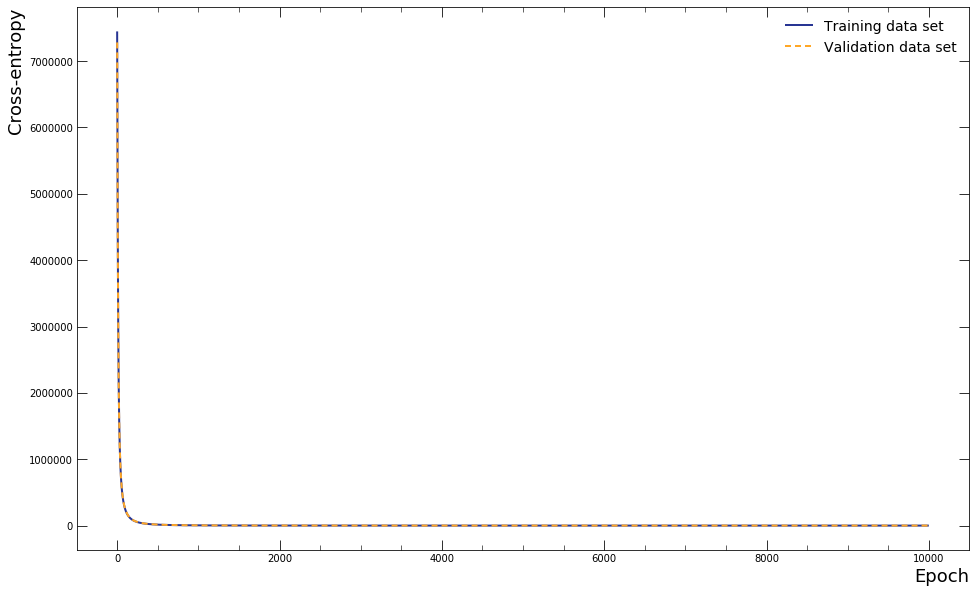

In [86]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

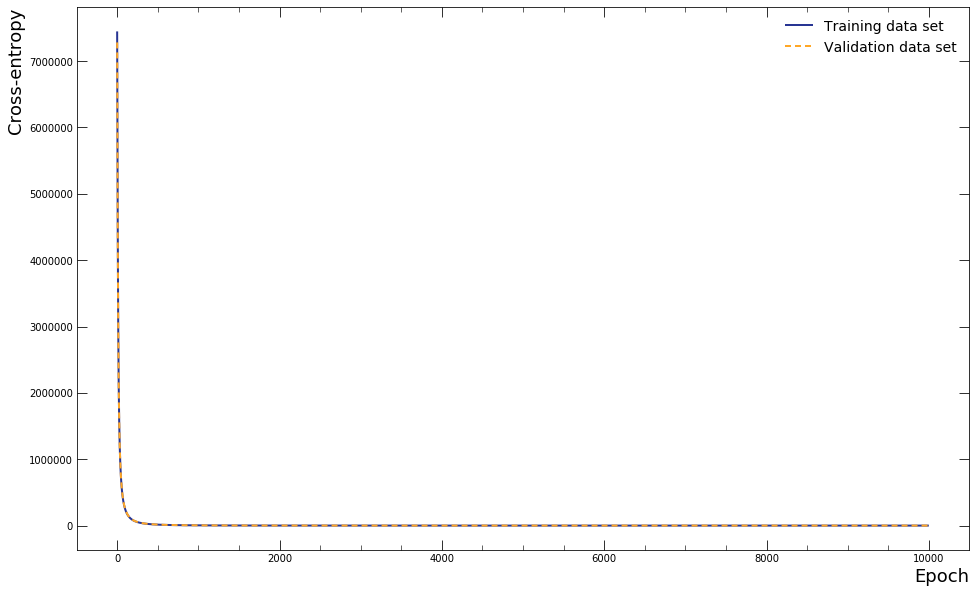

In [87]:
plot_loss(history)

## Training Set

In [122]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_train_new = []
lumi_new = []
lumi = data[str(runs[0])]['lumiid'] 

for l in range(len(x_train)):
    if not 0 in x_train[l]:
        x_train_new.append(x_train[l])
        for i in range(WINDOW):
            lumi_new.append(lumi[l+i])
                
reconstructed = model.predict(np.array(x_train))

error = abs(x_train-reconstructed)/x_train

In [123]:
error_reformat = []
for i in range(6):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(6):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(6):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(6):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_train_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_train_new[i][WINDOW*j])

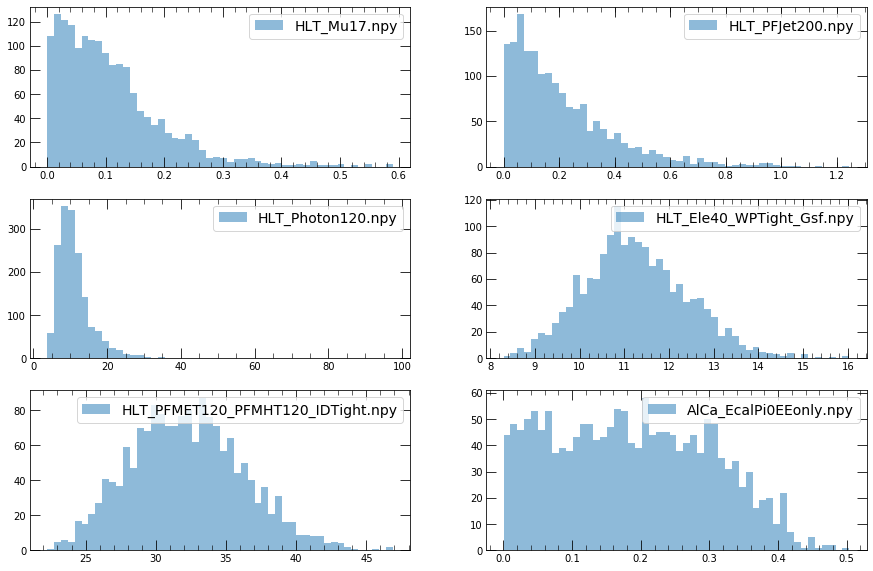

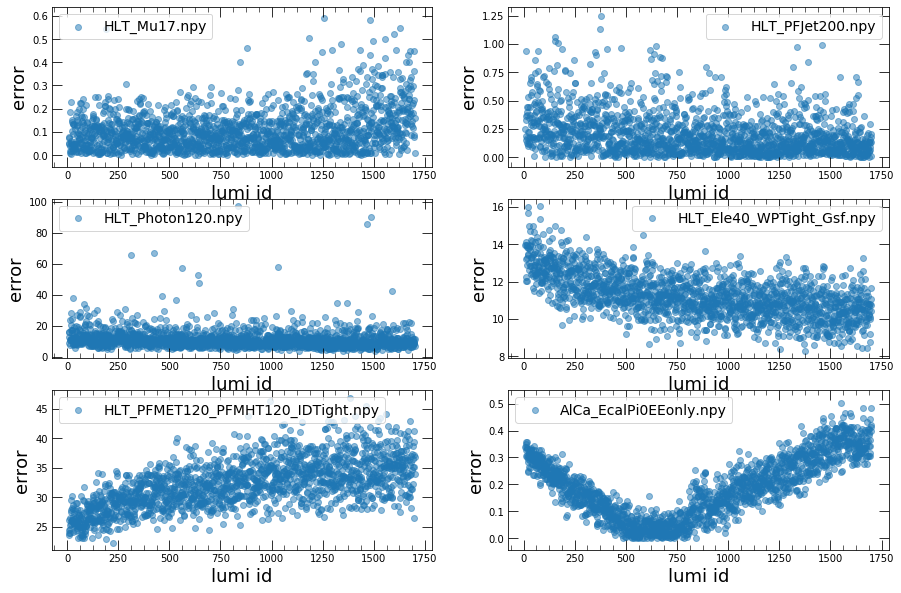

In [124]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat)):
    plt.subplot(3,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(0,6):
    plt.subplot(3,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

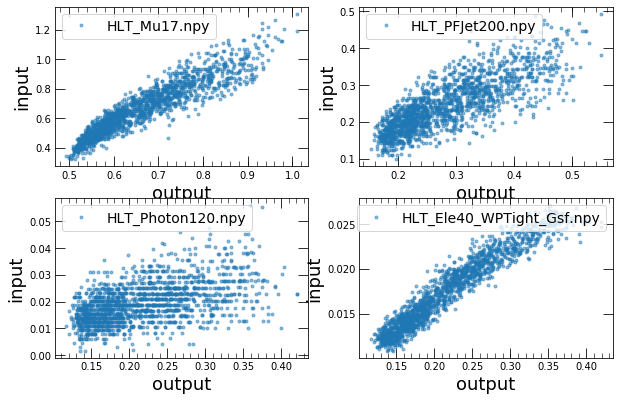

In [125]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(3,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

## Test Data

In [129]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = abs(x_test_new-reconstructed)/x_test_new

In [130]:
error_reformat = []
for i in range(6):
    error_reformat.append([])

for i in range(len(error)):
    #print(len(error_reformat[0]))
    for j in range(6):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(6):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(6):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_test_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_test_new[i][WINDOW*j])

ValueError: x and y must be the same size

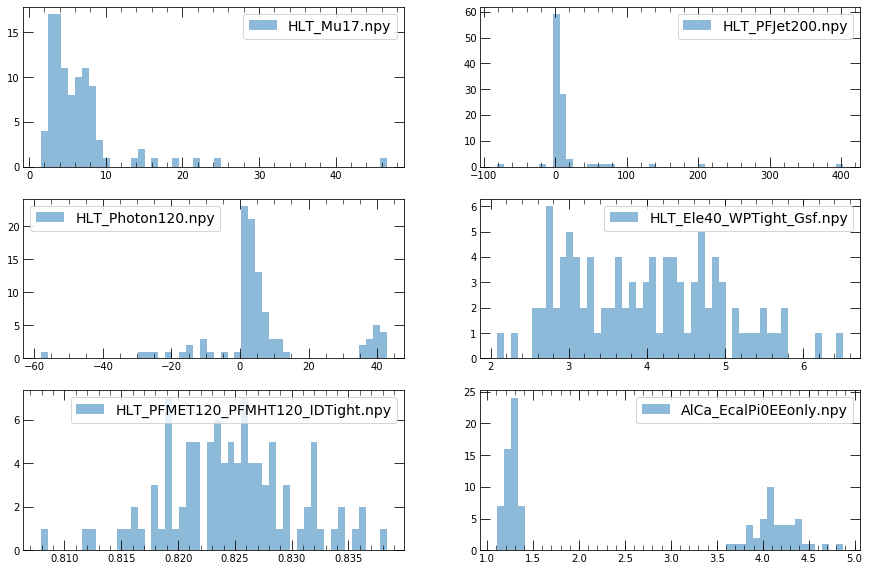

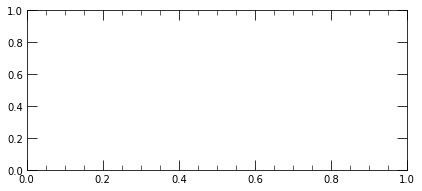

In [131]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat)):
    plt.subplot(3,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(0,6):
    plt.subplot(3,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

In [ ]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(3,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

In [ ]:
# plt.figure(figsize=[15,10])
# for i in range(0,4):
#     plt.subplot(3,2,i+1)
#     plt.scatter(lumi,inp[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [ ]:
# for i in range(len(outp)):
#     for j in range(i+1,len(outp)):
#         print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

## Fake Bad Data

In [ ]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [ ]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [ ]:
error_reformat_bad = []
for i in range(6):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(6):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(6):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

In [ ]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(3,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(error_reformat[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[15,10])
for i in range(0,6):
    plt.subplot(3,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

In [ ]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(3,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    plt.legend()    

plt.show()

In [ ]:
# plt.figure(figsize=[15,10])
# for i in range(0,4):
#     plt.subplot(3,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [ ]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[15,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(3,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[15,10])
# # for i in range(0,4):
# #     plt.subplot(3,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Fake Bad Data - ALL

In [ ]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [ ]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [ ]:
error_reformat_bad = []
for i in range(6):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(6):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(6):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

In [ ]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(3,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[15,10])
for i in range(0,6):
    plt.subplot(3,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

In [ ]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(3,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

In [ ]:
# plt.figure(figsize=[15,10])
# for i in range(0,4):
#     plt.subplot(3,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [ ]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[15,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(3,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[15,10])
# # for i in range(0,4):
# #     plt.subplot(3,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Real Bad Data

In [ ]:
bad_runs = [301480]

with open('normedAvg_bad.pickle', 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [ ]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [ ]:
error_reformat_bad = []
for i in range(6):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(6):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(6):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

In [ ]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(3,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[15,10])
for i in range(0,6):
    plt.subplot(3,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

In [ ]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(3,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

## Real Bad Data

In [ ]:
bad_runs = [305588]

with open('normedAvg_bad.pickle', 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [ ]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [ ]:
error_reformat_bad = []
for i in range(6):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(6):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(6):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(6):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

In [ ]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[15,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(3,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[15,10])
for i in range(0,6):
    plt.subplot(3,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

In [ ]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(3,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('ouput')
    plt.ylabel('input')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()